In [412]:
# Librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [413]:
# STEP 1: INITIAL PREPARATION
import pandas as pd
import numpy as np


# 1. LOADING 3 MONTHS
df1 = pd.read_csv('mois1.csv', sep=';')
df2 = pd.read_csv('mois2.csv', sep=';')
df3 = pd.read_csv('mois3.csv', sep=';')

print(f"df1 (Mois1): {df1.shape}")
print(f"df2 (Mois2): {df2.shape}")
print(f"df3 (Mois3): {df3.shape}")

# 2. DATES CONVERSION
df2["DATE_ACTIVATION"] = pd.to_datetime(df2["DATE_ACTIVATION"], dayfirst=True, errors="coerce")
df3["DATE_ACTIVATION"] = pd.to_datetime(df3["DATE_ACTIVATION"], dayfirst=True, errors="coerce")

# 3. VÉRIFICATION DES DATES
max_date_df2 = df2["DATE_ACTIVATION"].max()
max_date_df3 = df3["DATE_ACTIVATION"].max()
print(f"\nDate max df2 : {max_date_df2}")
print(f"Date max df3 : {max_date_df3}")

nb_newer = (df3["DATE_ACTIVATION"] > max_date_df2).sum()
print(f"activated customers after M2 : {nb_newer}")

# 4. TMISSING VALUES TREATMENT (FLOAT -> 0)
float_cols_df2 = df2.select_dtypes(include=["float64"]).columns
df2[float_cols_df2] = df2[float_cols_df2].fillna(0)

float_cols_df3 = df3.select_dtypes(include=["float64"]).columns
df3[float_cols_df3] = df3[float_cols_df3].fillna(0)

# Region -> Unknown
df2["region_administrative"] = df2["region_administrative"].fillna("Unknown")
df3["region_administrative"] = df3["region_administrative"].fillna("Unknown")



df1 (Mois1): (1425241, 15)
df2 (Mois2): (1446959, 15)
df3 (Mois3): (1471172, 15)

Date max df2 : 2025-11-30 00:00:00
Date max df3 : 2025-12-31 00:00:00
activated customers after M2 : 88139


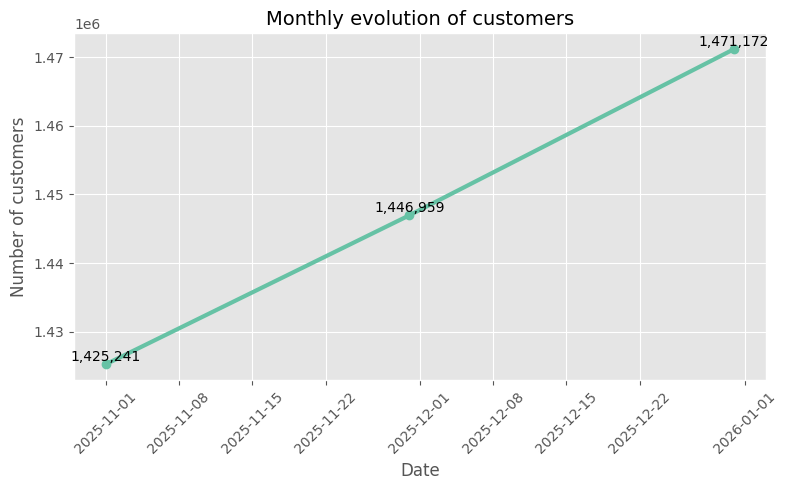

In [414]:

import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Données
# -----------------------------
data = {
    "Month": [
        "2025-11-01",
        "2025-11-30",
        "2025-12-31"
    ],
    "Number_of_customers": [
        1425241,
        1446959,
        1471172
    ]
}

df_timeline = pd.DataFrame(data)
df_timeline["Month"] = pd.to_datetime(df_timeline["Month"])

# -----------------------Number_of_customers------
# 2. Graphique
# -----------------------------
plt.figure(figsize=(8,5))

plt.plot(
    df_timeline["Month"],
    df_timeline["Number_of_customers"],
    marker="o",
    linewidth=3
)

# Ajouter les valeurs au-dessus des points
for i, value in enumerate(df_timeline["Number_of_customers"]):
    plt.text(
        df_timeline["Month"][i],
        value,
        f"{value:,}",
        ha="center",
        va="bottom"
    )

plt.title("Monthly evolution of customers", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of customers")
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [415]:
# ÉTAPE 2: COMBINATION M2-M3 ET TABLE  CREATION


df = df2.merge(df3[["ID", "arpu"]], on="ID", how="inner", suffixes=("_m2", "_m3"))

print(f"After Merging M2-M3: {df.shape}")
print(f"Customers present in M2 and  M3: {df.shape[0]:,}")

# Target creation
df['down_sell'] = 0
condition = df['arpu_m3'] <= 0.75 * df['arpu_m2']
df.loc[condition, 'down_sell'] = 1

print(f"Rate of down_sell: {df['down_sell'].mean()*100:.2f}%")

After Merging M2-M3: (1358344, 16)
Customers present in M2 and  M3: 1,358,344
Rate of down_sell: 52.76%


In [416]:
# step 3 adding month 3


df = df.merge(df1[['ID', 'arpu']], on='ID', how='left')
df.rename(columns={'arpu': 'arpu_m1'}, inplace=True)

print(f"Clients with arpu_m1: {df['arpu_m1'].notna().sum():,} sur {len(df):,}")
print(f"Soit {df['arpu_m1'].notna().sum()/len(df)*100:.2f}%")

Clients with arpu_m1: 1,182,058 sur 1,358,344
Soit 87.02%


In [417]:
# ÉTAPE 4: CREATION VARIATION M1-M2 


df['variation_m1_m2'] = (df['arpu_m2'] - df['arpu_m1']) / df['arpu_m1']
df['variation_m1_m2'] = df['variation_m1_m2'].replace([np.inf, -np.inf], np.nan)


print(df['variation_m1_m2'].describe())

# interim Class
conditions = [
    df['variation_m1_m2'] < -0.25,
    (df['variation_m1_m2'] >= -0.25) & (df['variation_m1_m2'] <= 0.25),
    df['variation_m1_m2'] > 0.25
]
choices = ['Declining', 'Unchanged', 'Growing']
df['class_variation_m1_m2'] = np.select(conditions, choices, default='Inconnue')


print(df['class_variation_m1_m2'].value_counts())

count    877720.000000
mean          5.522286
std         796.470929
min          -1.000000
25%          -0.711456
50%          -0.194025
75%           0.249969
max      462499.000000
Name: variation_m1_m2, dtype: float64
class_variation_m1_m2
Inconnue     480624
Declining    405809
Unchanged    254168
Growing      217743
Name: count, dtype: int64


In [418]:
# ÉTAPE 5: TReatment FINAL OF NAN


# État avant
print("BEFORE TREATMENT:")
print(f"arpu_m1 - NaN: {df['arpu_m1'].isna().sum():,}")
print(f"variation_m1_m2 - NaN: {df['variation_m1_m2'].isna().sum():,}")

# Replacement of arpu_m1 NaN par 0
df['arpu_m1'] = df['arpu_m1'].fillna(0)

# Recalculer variation (propre)
df['variation_m1_m2'] = 0.0
mask = df['arpu_m1'] > 0
df.loc[mask, 'variation_m1_m2'] = (df.loc[mask, 'arpu_m2'] - df.loc[mask, 'arpu_m1']) / df.loc[mask, 'arpu_m1']

# Recalculer classes
conditions = [
    df['variation_m1_m2'] < -0.25,
    (df['variation_m1_m2'] >= -0.25) & (df['variation_m1_m2'] <= 0.25),
    df['variation_m1_m2'] > 0.25
]
choices = ['Declining', 'Unchanged', 'Growing']
df['class_variation_m1_m2'] = np.select(conditions, choices, default='Inconnue')

# État après
print("\nAFTER TREATMENT:")
print(f"arpu_m1 - NaN: {df['arpu_m1'].isna().sum()}")
print(f"variation_m1_m2 - NaN: {df['variation_m1_m2'].isna().sum()}")

print("\nDistribution final:")
print(df['class_variation_m1_m2'].value_counts())
print("\nPercentages:")
print(df['class_variation_m1_m2'].value_counts(normalize=True).mul(100).round(1))

BEFORE TREATMENT:
arpu_m1 - NaN: 176,286
variation_m1_m2 - NaN: 480,624

AFTER TREATMENT:
arpu_m1 - NaN: 0
variation_m1_m2 - NaN: 0

Distribution final:
class_variation_m1_m2
Unchanged    734792
Declining    405809
Growing      217743
Name: count, dtype: int64

Percentages:
class_variation_m1_m2
Unchanged    54.1
Declining    29.9
Growing      16.0
Name: proportion, dtype: float64



Link with down_sell:
                       % Stable M2-M3  % Down-sell M2-M3
class_variation_m1_m2                                   
Declining                        53.2               46.8
Growing                          57.5               42.5
Unchanged                        40.9               59.1


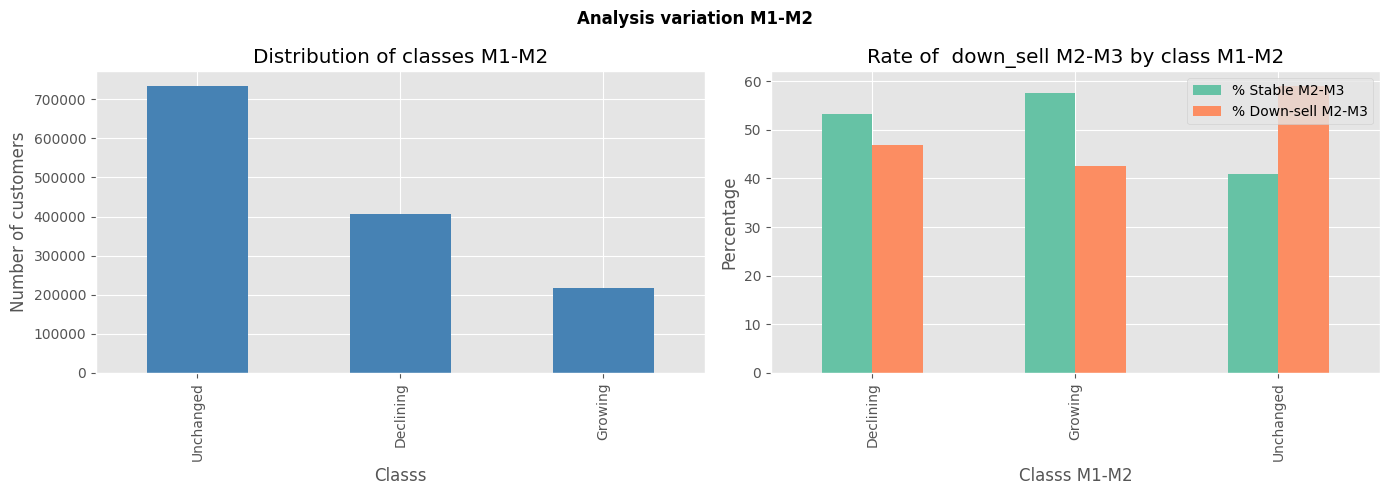

In [419]:
# ÉTAPE 6: ANALYSIS FINAL


if 'down_sell' in df.columns:
    croisement = pd.crosstab(
        df['class_variation_m1_m2'], 
        df['down_sell'],
        normalize='index'
    ) * 100
    croisement.columns = ['% Stable M2-M3', '% Down-sell M2-M3']
    print("\nLink with down_sell:")
    print(croisement.round(1))
    
    # Graphic
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    df['class_variation_m1_m2'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Distribution of classes M1-M2')
    axes[0].set_xlabel('Classs')
    axes[0].set_ylabel('Number of customers')
    
    croisement.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Rate of  down_sell M2-M3 by class M1-M2')
    axes[1].set_xlabel('Classs M1-M2')
    axes[1].set_ylabel('Percentage')
    axes[1].legend(loc='upper right')
    
    plt.suptitle('Analysis variation M1-M2', fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
df["down_sell"] = 0
df.loc[df["arpu_m3"] <= 0.75 * df["arpu_m2"], "down_sell"] = 1


date_reference = pd.to_datetime("2025-11-30")

df["seniority_days"] = (date_reference - df["DATE_ACTIVATION"]).dt.days

df["seniority_days"] = df["seniority_days"].fillna(-1)

seniority\_days which is the difference between maximum date of month 2 - activation date. The values are natural numbers


In [421]:
def classer_anciennete(x):
    if x == -1:
        return "Unknowned"
    elif x < 90:
        return "Recent"
    elif x < 270:
        return "Medium"
    elif x < 1080:
        return "Established"
    else:
        return "Loyal"

df["seniority_class"] = df["seniority_days"].apply(classer_anciennete)

# Verification
print(df["seniority_class"].value_counts())

seniority_class
Loyal          502707
Established    478419
Medium         214915
Recent         157711
Unknowned        4592
Name: count, dtype: int64


In [422]:
#Creation of  part_data
df["part_data"] = 0
df.loc[df["arpu_m2"] > 0, "part_data"] = df["arpu_data"] / df["arpu_m2"]

# Call intensity
df["Call_intensity"] = 0
df.loc[df["NB_J_VOIX"] > 0, "Call_intensity"] = df["MOU"] / df["NB_J_VOIX"]

#Variables binaires usage used_data used_OM
df["used_data"] = 0
df.loc[df["volume_data_in"] > 0, "used_data"] = 1

df["used_OM"] = 0
df.loc[df["OM_Montant"] > 0, "used_OM"] = 1
# double service
df["is_bi_service"] = 0
df.loc[(df["used_data"] == 1) & (df["used_OM"] == 1), "is_bi_service"] = 1

# use calls
df["used_voice"] = 0
df.loc[df["Call_intensity"] > 0, "used_voice"] = 1


# multi service
df["is_multi_service"] = 0
df.loc[(df["is_bi_service"] == 1) & (df["used_voice"] == 1), "is_multi_service"] = 1



#Classe ARPU
def classe_arpu(x):
    if x < 2000:
        return "Weak_class"
    elif x < 5000:
        return "Average_class"
    else:
        return "Strong_class"

df["class_arpu"] = df["arpu_m2"].apply(classe_arpu)

#Classe Data
def classe_data(x):
    if x == 0:
        return "None"
    elif x < 500:
        return "Weak"
    elif x < 2000:
        return "Average"
    else:
        return "Strong"

df["class_data"] = df["volume_data_in"].apply(classe_data)


C:\Users\USER\AppData\Local\Temp\ipykernel_30068\2437407011.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.79375    1.         0.85034014 ... 0.         0.62       0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["arpu_m2"] > 0, "part_data"] = df["arpu_data"] / df["arpu_m2"]
C:\Users\USER\AppData\Local\Temp\ipykernel_30068\2437407011.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[22.          0.335       3.9        ...  7.25818182 12.183
  3.40307692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["NB_J_VOIX"] > 0, "Call_intensity"] = df["MOU"] / df["NB_J_VOIX"]


In [423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358344 entries, 0 to 1358343
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   arpu_m2                1358344 non-null  float64       
 1   arpu_voix              1358344 non-null  float64       
 2   arpu_data              1358344 non-null  float64       
 3   MOU                    1358344 non-null  float64       
 4   NB_J_REVENU            1358344 non-null  float64       
 5   NB_J_VOIX              1358344 non-null  float64       
 6   nb_j_data              1358344 non-null  float64       
 7   nb_jr_activite         1358344 non-null  float64       
 8   volume_data_in         1358344 non-null  float64       
 9   DATE_ACTIVATION        1353752 non-null  datetime64[ns]
 10  region_administrative  1358344 non-null  object        
 11  handset                1358344 non-null  object        
 12  OM_Montant             13583

In [424]:
print("=== DISTRIBUTION DOWN_SELL ===")
print(df["down_sell"].value_counts())
print(f"down_sell rate: {df['down_sell'].mean()*100:.2f}%")

=== DISTRIBUTION DOWN_SELL ===
down_sell
1    716657
0    641687
Name: count, dtype: int64
down_sell rate: 52.76%


In [425]:
print("=== CLIENTS WITH UNKNOWNED DATES ===")
clients_date_inconnue = df[df["seniority_days"] == -1]
print(f"Number: {len(clients_date_inconnue)}")
print(f"That's {len(clients_date_inconnue)/len(df)*100:.2f}% of clients")

=== CLIENTS WITH UNKNOWNED DATES ===
Number: 4592
That's 0.34% of clients


In [426]:
df.shape

(1358344, 31)

In [427]:
unknown_date = df[df["seniority_days"] == -1]

print("=== PROFILE OF CUSTOMERS WITH UNKNOWN DATE ===")
print(f"Count: {len(unknown_date)}")

print(f"\nDownsell rate (unknown date): {unknown_date['down_sell'].mean()*100:.2f}%")
print(f"Global downsell rate: {df['down_sell'].mean()*100:.2f}%")

print("\nAverage ARPU:", unknown_date["arpu_m2"].mean())
print("Average MOU:", unknown_date["MOU"].mean())
print("Multi-service rate:", unknown_date["is_multi_service"].mean())

print("\nARPU class distribution:")
print(unknown_date["class_arpu"].value_counts(normalize=True))

=== PROFILE OF CUSTOMERS WITH UNKNOWN DATE ===
Count: 4592

Downsell rate (unknown date): 89.98%
Global downsell rate: 52.76%

Average ARPU: 17.82070775261324
Average MOU: 0.39285496515679447
Multi-service rate: 0.00043554006968641115

ARPU class distribution:
class_arpu
Weak_class       0.998911
Average_class    0.000653
Strong_class     0.000436
Name: proportion, dtype: float64


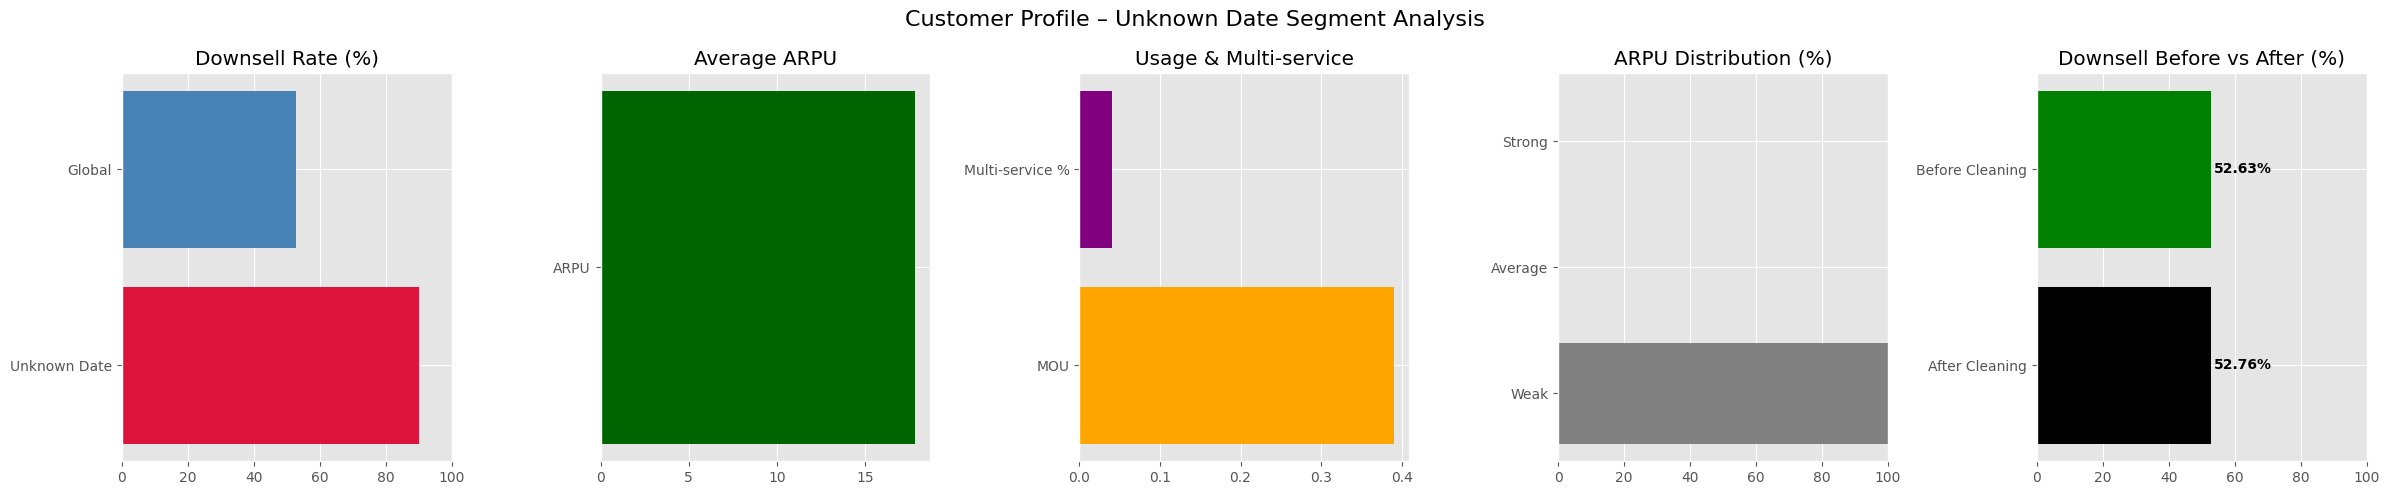

In [428]:
import matplotlib.pyplot as plt

# -------------------------
# 1. Manual Data
# -------------------------

downsell_unknown = 89.98
downsell_global = 52.76

avg_arpu = 17.82
avg_mou = 0.39
multi_service_rate = 0.04  # %

downsell_before = 52.76
downsell_after = 52.63

arpu_distribution = {
    "Weak": 99.89,
    "Average": 0.07,
    "Strong": 0.04
}

# -------------------------
# 2. Create Horizontal Dashboard
# -------------------------

fig, axes = plt.subplots(1, 5, figsize=(24, 5))

# --- Graph 1
axes[0].barh(["Unknown Date", "Global"], 
             [downsell_unknown, downsell_global],
             color=["crimson", "steelblue"])
axes[0].set_title("Downsell Rate (%)")
axes[0].set_xlim(0, 100)

# --- Graph 2
axes[1].barh(["ARPU"], [avg_arpu], color="darkgreen")
axes[1].set_title("Average ARPU")

# --- Graph 3
axes[2].barh(["MOU", "Multi-service %"], 
             [avg_mou, multi_service_rate],
             color=["orange", "purple"])
axes[2].set_title("Usage & Multi-service")

# --- Graph 4
axes[3].barh(list(arpu_distribution.keys()),
             list(arpu_distribution.values()),
             color=["gray", "blue", "gold"])
axes[3].set_title("ARPU Distribution (%)")
axes[3].set_xlim(0, 100)

# --- Graph 5 (WITH PERCENTAGE LABELS)
bars = axes[4].barh(
      ["After Cleaning","Before Cleaning"],
    [downsell_before, downsell_after],
    color=["black", "green"]
)

axes[4].set_title("Downsell Before vs After (%)")
axes[4].set_xlim(0, 100)

# Add percentage labels at bar tips
for bar in bars:
    width = bar.get_width()
    axes[4].text(
        width + 1,                 # slightly to the right of bar
        bar.get_y() + bar.get_height()/2,
        f"{width:.2f}%",
        va="center",
        fontsize=10,
        fontweight="bold"
    )

plt.suptitle("Customer Profile – Unknown Date Segment Analysis", fontsize=16)
plt.tight_layout()
plt.show()

In [429]:
# Remove customers with unknown date
df_clean = df[df["seniority_days"] != -1].copy()

print(f"Before: {len(df)} customers")
print(f"After: {len(df_clean)} customers")
print(f"Removed: {len(df) - len(df_clean)} customers ({100*(len(df) - len(df_clean))/len(df):.2f}%)")

# Check impact on target
print(f"\nDownsell rate before: {df['down_sell'].mean()*100:.2f}%")
print(f"Downsell rate after: {df_clean['down_sell'].mean()*100:.2f}%")

Before: 1358344 customers
After: 1353752 customers
Removed: 4592 customers (0.34%)

Downsell rate before: 52.76%
Downsell rate after: 52.63%


In [430]:
df.columns

Index(['arpu_m2', 'arpu_voix', 'arpu_data', 'MOU', 'NB_J_REVENU', 'NB_J_VOIX',
       'nb_j_data', 'nb_jr_activite', 'volume_data_in', 'DATE_ACTIVATION',
       'region_administrative', 'handset', 'OM_Montant', 'OM_nb_jr_activite',
       'ID', 'arpu_m3', 'down_sell', 'arpu_m1', 'variation_m1_m2',
       'class_variation_m1_m2', 'seniority_days', 'seniority_class',
       'part_data', 'Call_intensity', 'used_data', 'used_OM', 'is_bi_service',
       'used_voice', 'is_multi_service', 'class_arpu', 'class_data'],
      dtype='object')

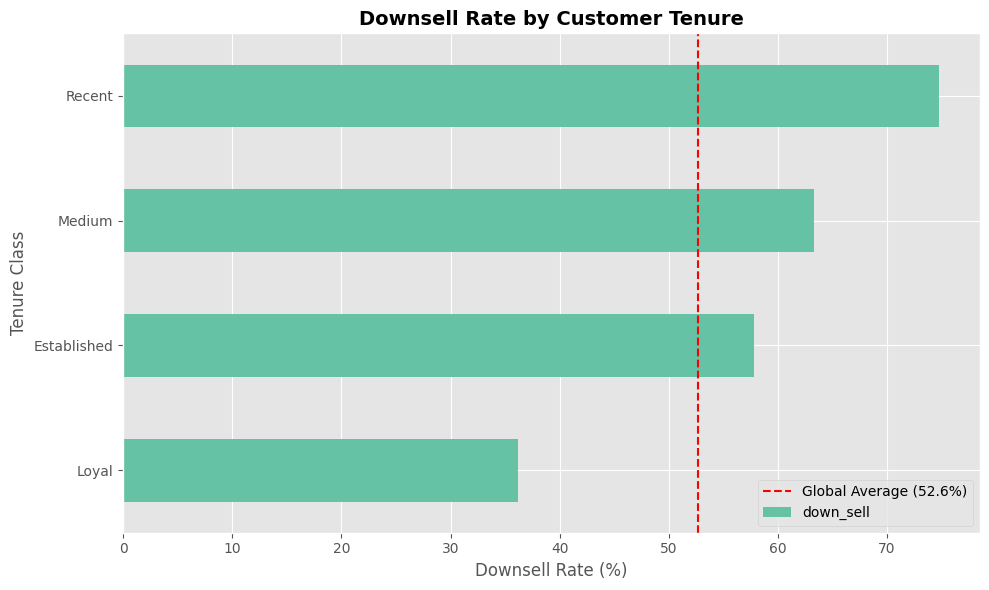

seniority_class
Loyal          36.2
Established    57.8
Medium         63.3
Recent         74.8
Name: down_sell, dtype: float64


In [431]:

# -------------------------
# Style
# -------------------------
plt.style.use('ggplot')
sns.set_palette("Set2")

# Downsell rate by customer tenure class
downsell_by_tenure = df_clean.groupby("seniority_class")["down_sell"].mean().sort_values() * 100

plt.figure(figsize=(10, 6))
downsell_by_tenure.plot(kind="barh")
plt.title("Downsell Rate by Customer Tenure", fontsize=14, fontweight="bold")
plt.xlabel("Downsell Rate (%)")
plt.ylabel("Tenure Class")

# Add global mean line
plt.axvline(
    x=df_clean["down_sell"].mean() * 100,
    color='red',
    linestyle='--',
    label=f'Global Average ({df_clean["down_sell"].mean()*100:.1f}%)'
)
plt.legend()
plt.tight_layout()
plt.show()

# Print downsell rate per tenure class
print(downsell_by_tenure.round(1))

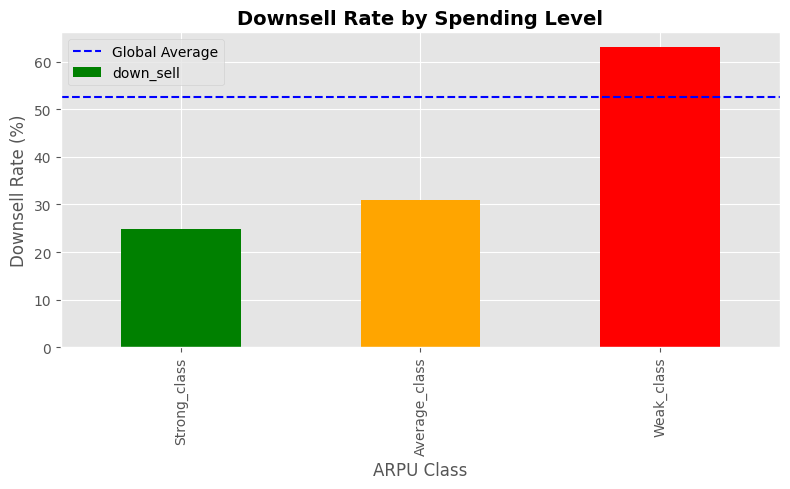

class_arpu
Strong_class     24.8
Average_class    31.0
Weak_class       63.1
Name: down_sell, dtype: float64


In [432]:
import matplotlib.pyplot as plt

# Downsell rate by ARPU class
downsell_by_arpu = df_clean.groupby("class_arpu")["down_sell"].mean().sort_values() * 100

plt.figure(figsize=(8, 5))
downsell_by_arpu.plot(kind="bar", color=["green", "orange", "red"])
plt.title("Downsell Rate by Spending Level", fontsize=14, fontweight="bold")
plt.xlabel("ARPU Class")
plt.ylabel("Downsell Rate (%)")

# Add global mean line
plt.axhline(
    y=df_clean["down_sell"].mean() * 100,
    color='blue',
    linestyle='--',
    label='Global Average'
)
plt.legend()
plt.tight_layout()
plt.show()

# Print downsell rate per ARPU class
print(downsell_by_arpu.round(1))

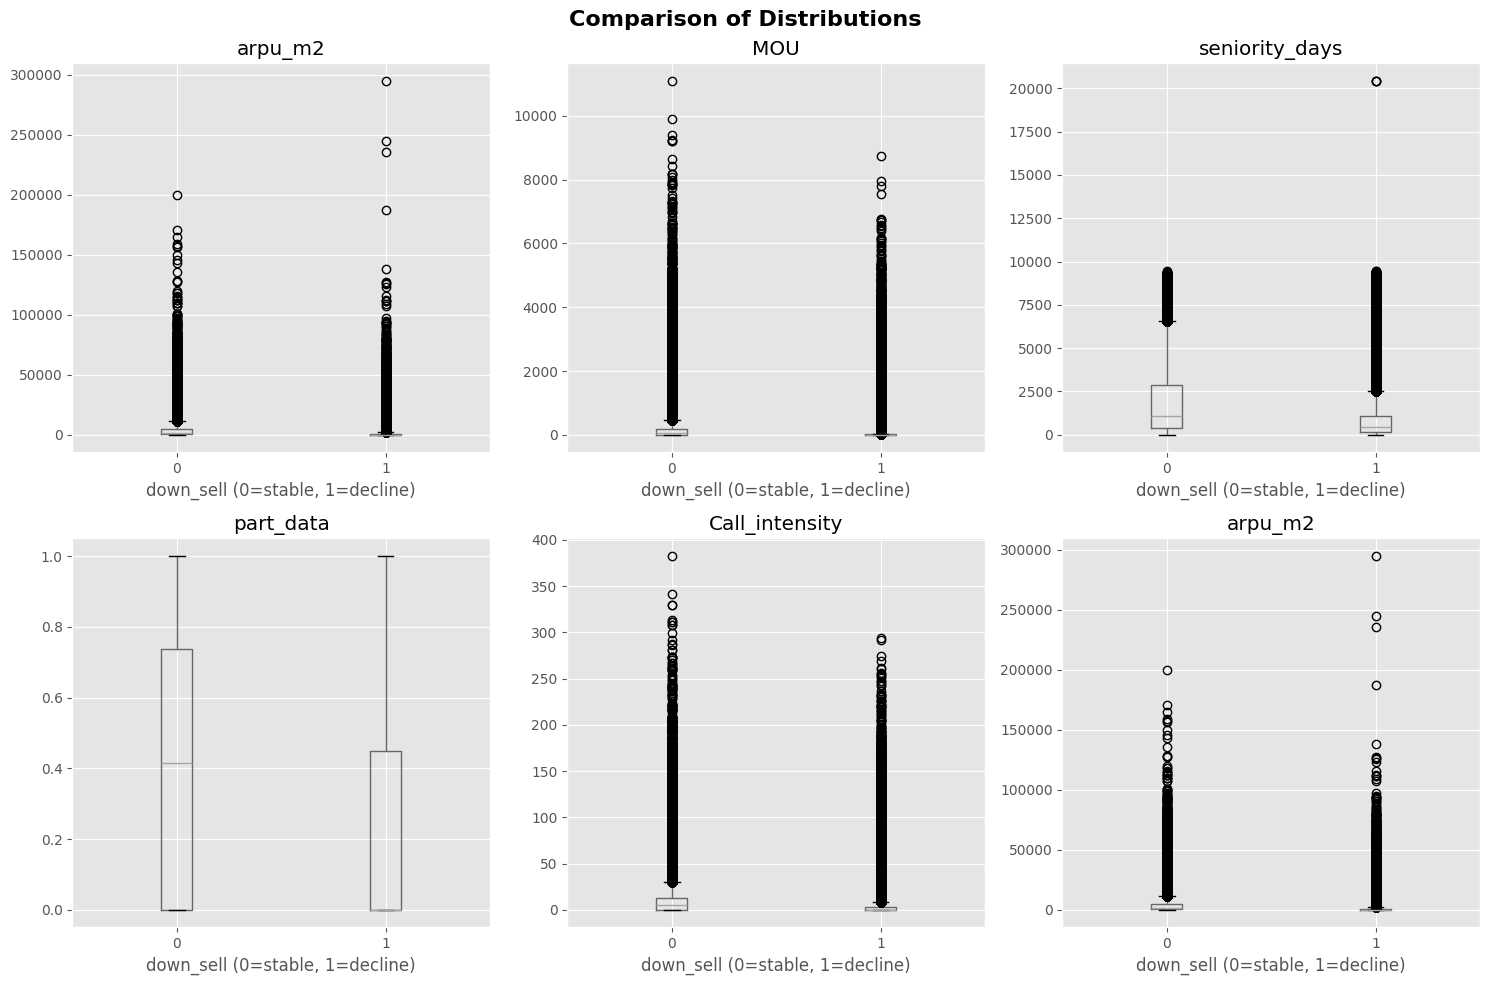

=== MEANS ===
                Stables (0)  Down-sellers (1)
arpu_m2             3641.28           1191.70
MOU                  162.16             54.56
seniority_days      1904.75            985.62
part_data              0.41              0.25
Call_intensity         9.10              3.93
arpu_m2             3641.28           1191.70


In [433]:

# Select some key variables
# -------------------------
variables_to_compare = ["arpu_m2", "MOU", "seniority_days", "part_data", "Call_intensity", "arpu_m2"]

# Create a dataframe with group means
comparison = df_clean.groupby("down_sell")[variables_to_compare].mean().T
comparison.columns = ["Stables (0)", "Down-sellers (1)"]

# -------------------------
# Boxplots
# -------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(variables_to_compare):
    df_clean.boxplot(column=var, by="down_sell", ax=axes[i])
    axes[i].set_title(f"{var}")
    axes[i].set_xlabel("down_sell (0=stable, 1=decline)")

plt.suptitle("Comparison of Distributions", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# -------------------------
# Print means
# -------------------------
print("=== MEANS ===")
print(comparison.round(2))

In [434]:
df_clean[['Call_intensity']]

,Call_intensity
0,0.000000
1,22.000000
2,0.000000
3,0.335000
4,0.000000
...,...
1358339,63.178667
1358340,7.258182
1358341,0.000000
1358342,12.183000


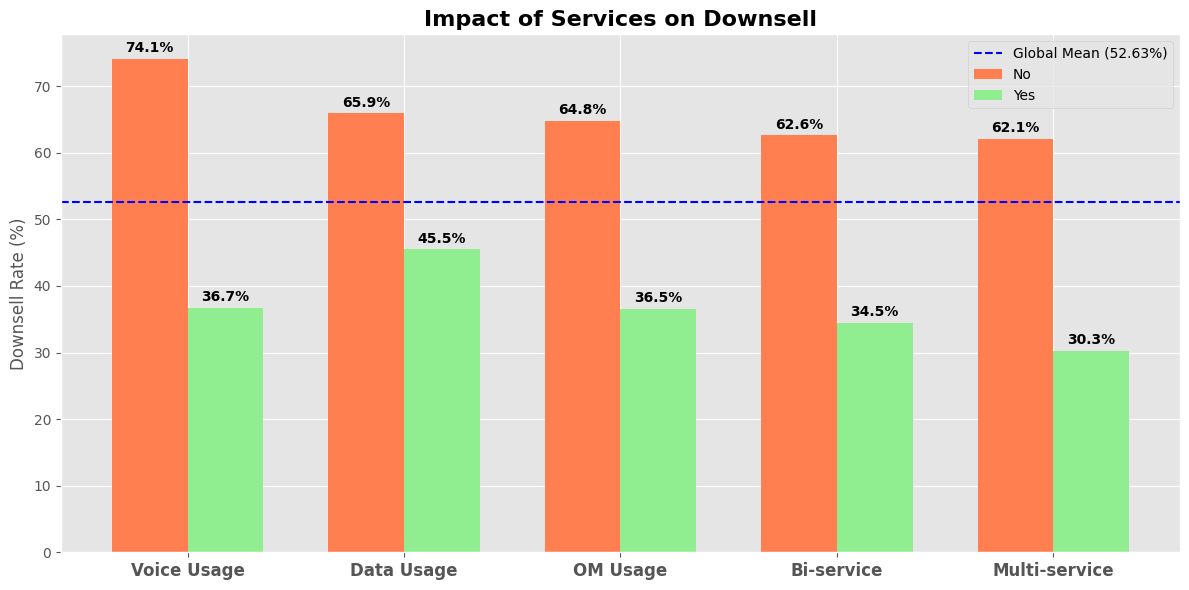

In [435]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Segments and their downsell rates
# -------------------------
segments = ["Voice Usage", "Data Usage", "OM Usage", "Bi-service", "Multi-service"]

bar_values = [
    [df_clean.groupby("used_voice")["down_sell"].mean()[0]*100,
     df_clean.groupby("used_voice")["down_sell"].mean()[1]*100],
    
    [df_clean.groupby("used_data")["down_sell"].mean()[0]*100,
     df_clean.groupby("used_data")["down_sell"].mean()[1]*100],
    
    [df_clean.groupby("used_OM")["down_sell"].mean()[0]*100,
     df_clean.groupby("used_OM")["down_sell"].mean()[1]*100],
    
    [df_clean.groupby("is_bi_service")["down_sell"].mean()[0]*100,
     df_clean.groupby("is_bi_service")["down_sell"].mean()[1]*100],
    
    [df_clean.groupby("is_multi_service")["down_sell"].mean()[0]*100,
     df_clean.groupby("is_multi_service")["down_sell"].mean()[1]*100]
]

x = np.arange(len(segments))
width = 0.35  # width of bars

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
ax.bar(x - width/2, [v[0] for v in bar_values], width, label="No", color="coral")
ax.bar(x + width/2, [v[1] for v in bar_values], width, label="Yes", color="lightgreen")

# Global mean line
global_mean = df_clean["down_sell"].mean() * 100
ax.axhline(global_mean, color='blue', linestyle='--', label=f'Global Mean ({global_mean:.2f}%)')

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(segments, fontsize=12, fontweight="bold")
ax.set_ylabel("Downsell Rate (%)", fontsize=12)
ax.set_title("Impact of Services on Downsell", fontsize=16, fontweight="bold")
ax.legend()

# Add value labels on top of bars
for i in range(len(segments)):
    ax.text(x[i] - width/2, bar_values[i][0] + 1, f"{bar_values[i][0]:.1f}%", 
            ha='center', fontweight='bold')
    ax.text(x[i] + width/2, bar_values[i][1] + 1, f"{bar_values[i][1]:.1f}%", 
            ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

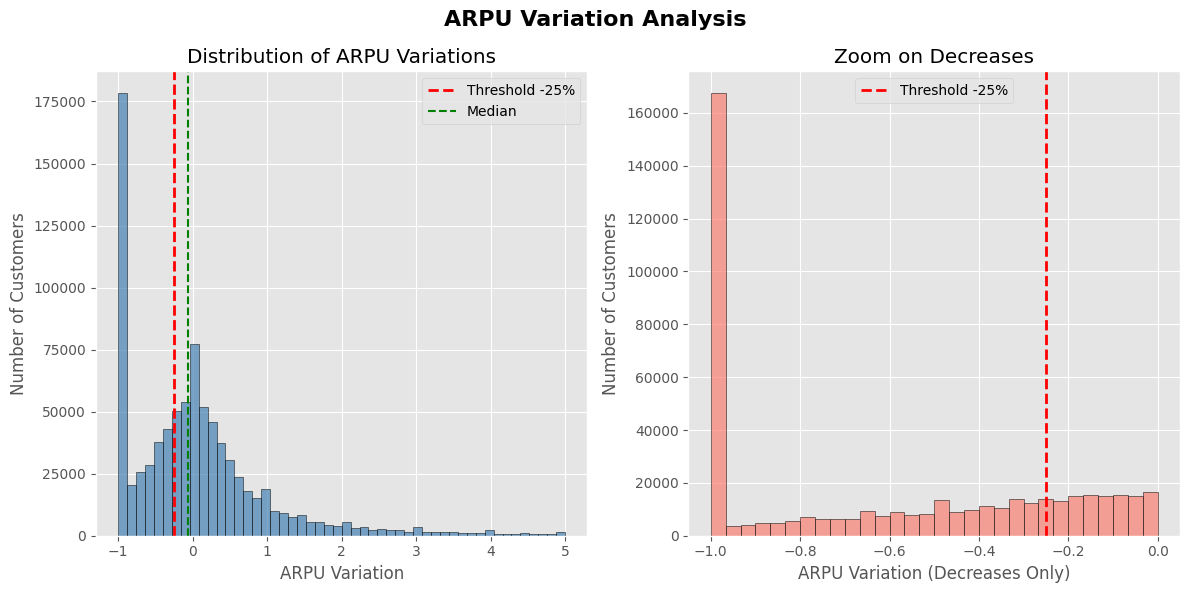

Median of variations: -6.1%
% of customers with decrease: 53.3%


In [436]:

# -------------------------
# Calculate ARPU variation if not already done
# -------------------------
if "variation" not in df_clean.columns:
    df_clean["variation"] = (df_clean["arpu_m3"] - df_clean["arpu_m2"]) / df_clean["arpu_m2"]
    # Clean extreme values
    df_clean = df_clean[df_clean["variation"].between(-1, 5)]  # between -100% and +500%

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(12, 6))

# --- Full histogram
plt.subplot(1, 2, 1)
plt.hist(df_clean["variation"], bins=50, alpha=0.7, color="steelblue", edgecolor="black")
plt.axvline(x=-0.25, color='red', linestyle='--', linewidth=2, label='Threshold -25%')
plt.axvline(x=df_clean["variation"].median(), color='green', linestyle='--', label='Median')
plt.xlabel("ARPU Variation")
plt.ylabel("Number of Customers")
plt.title("Distribution of ARPU Variations")
plt.legend()

# --- Zoom on decreases only
plt.subplot(1, 2, 2)
decreases = df_clean[df_clean["variation"] < 0]["variation"]
plt.hist(decreases, bins=30, alpha=0.7, color="salmon", edgecolor="black")
plt.axvline(x=-0.25, color='red', linestyle='--', linewidth=2, label='Threshold -25%')
plt.xlabel("ARPU Variation (Decreases Only)")
plt.ylabel("Number of Customers")
plt.title("Zoom on Decreases")
plt.legend()

plt.suptitle("ARPU Variation Analysis", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# -------------------------
# Summary statistics
# -------------------------
print(f"Median of variations: {df_clean['variation'].median()*100:.1f}%")
print(f"% of customers with decrease: {(df_clean['variation'] < 0).mean()*100:.1f}%")

C:\Users\USER\AppData\Local\Temp\ipykernel_30068\1220108190.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.values, y=region_counts.index, palette='viridis')


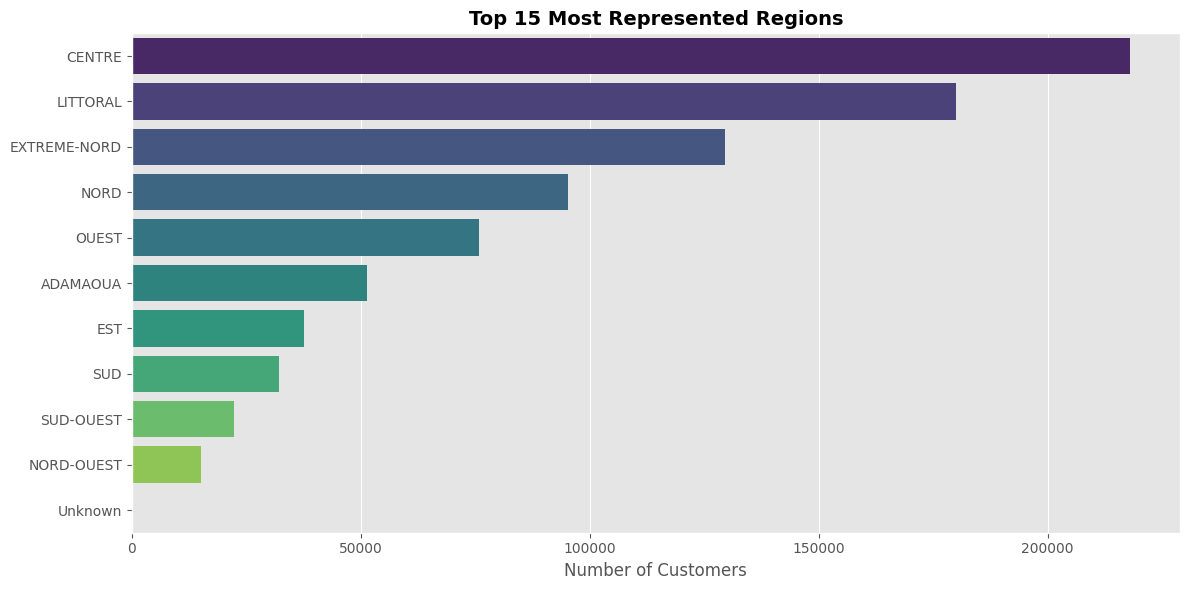

C:\Users\USER\AppData\Local\Temp\ipykernel_30068\1220108190.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_down.values*100, y=region_down.index, palette='Reds_r')


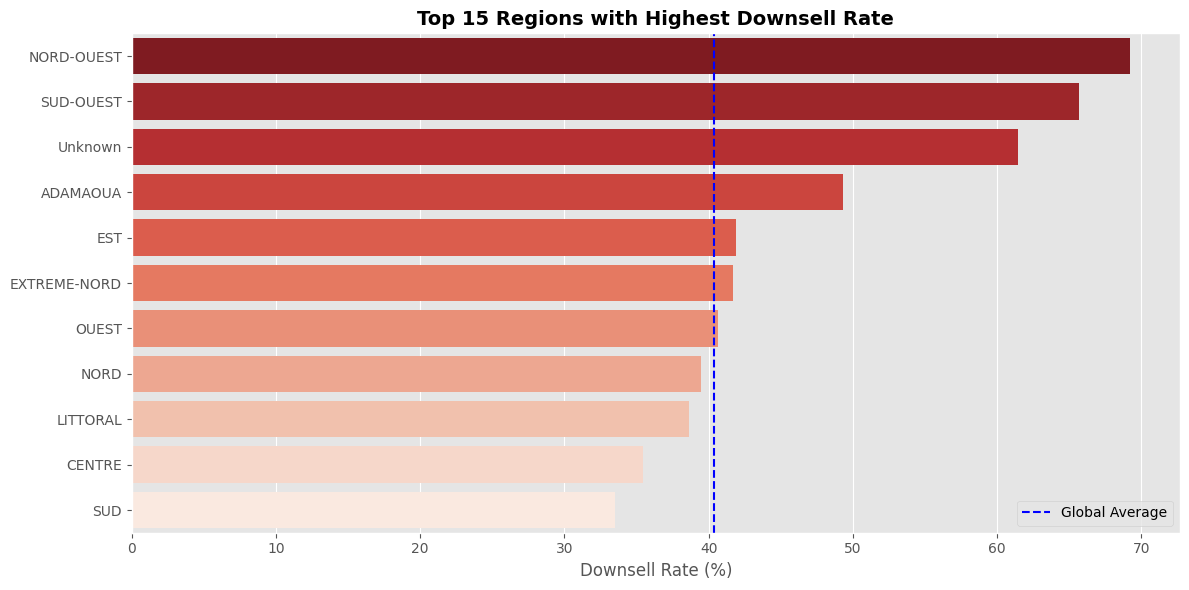

In [437]:


# Distribution of customers by region

plt.figure(figsize=(12, 6))
region_counts = df_clean['region_administrative'].value_counts().head(15)
sns.barplot(x=region_counts.values, y=region_counts.index, palette='viridis')
plt.title('Top 15 Most Represented Regions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Customers')
plt.ylabel('')
plt.tight_layout()
plt.show()

# -------------------------
# Downsell rate by region
# -------------------------
region_down = df_clean.groupby('region_administrative')['down_sell'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=region_down.values*100, y=region_down.index, palette='Reds_r')
plt.title('Top 15 Regions with Highest Downsell Rate', fontsize=14, fontweight='bold')
plt.xlabel('Downsell Rate (%)')
plt.ylabel('')
plt.axvline(x=df_clean['down_sell'].mean()*100, color='blue', linestyle='--', label='Global Average')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_30068\986000946.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=handset_counts.values, y=handset_counts.index, palette='coolwarm')


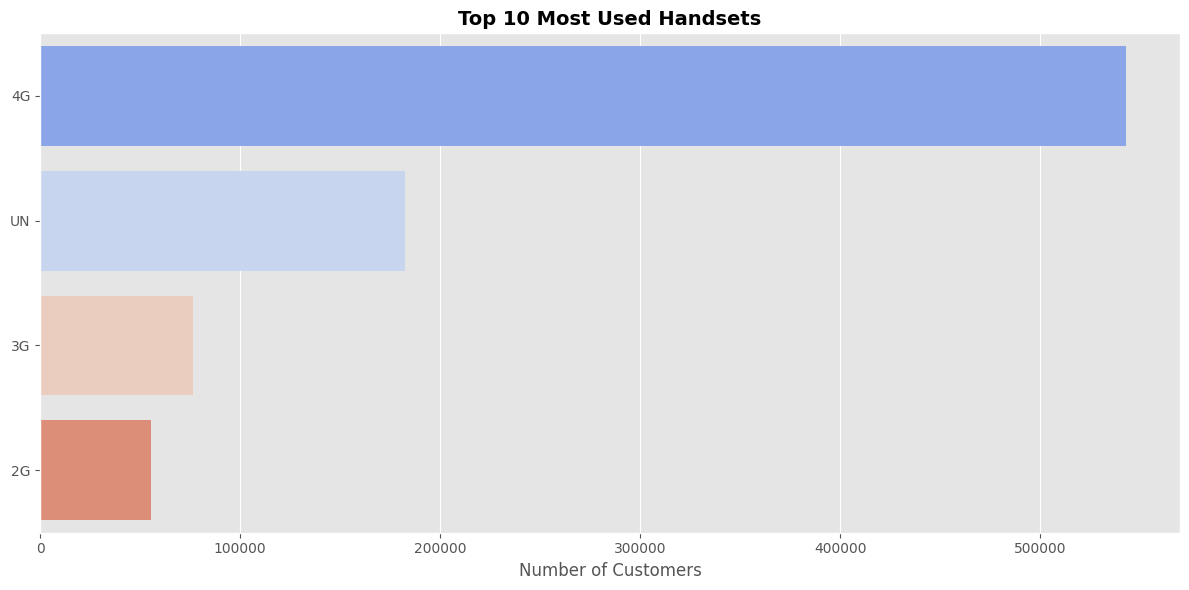

C:\Users\USER\AppData\Local\Temp\ipykernel_30068\986000946.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=handset_down.values*100, y=handset_down.index, palette='Reds')


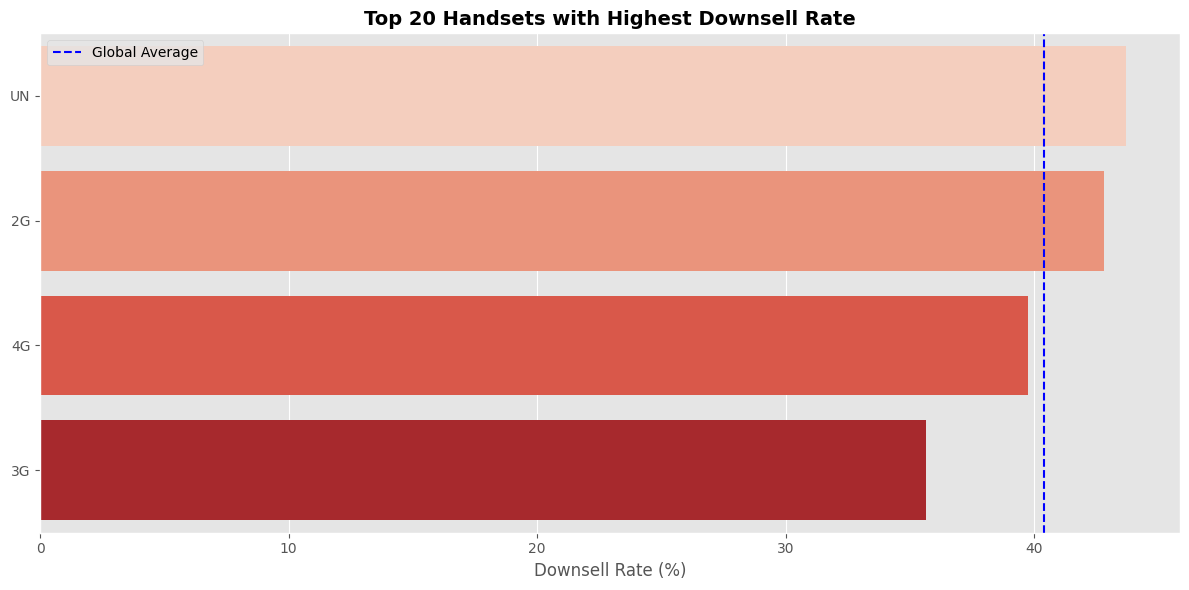

In [438]:

# -------------------------
# Top 10 handsets by number of customers
# -------------------------
plt.figure(figsize=(12, 6))
handset_counts = df_clean['handset'].value_counts().head(10)
sns.barplot(x=handset_counts.values, y=handset_counts.index, palette='coolwarm')
plt.title('Top 10 Most Used Handsets', fontsize=14, fontweight='bold')
plt.xlabel('Number of Customers')
plt.ylabel('')
plt.tight_layout()
plt.show()

# -------------------------
# Downsell rate by handset (top 20)
# -------------------------
handset_down = df_clean.groupby('handset')['down_sell'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=handset_down.values*100, y=handset_down.index, palette='Reds')
plt.title('Top 20 Handsets with Highest Downsell Rate', fontsize=14, fontweight='bold')
plt.xlabel('Downsell Rate (%)')
plt.ylabel('')
plt.axvline(x=df_clean['down_sell'].mean()*100, color='blue', linestyle='--', label='Global Average')
plt.legend()
plt.tight_layout()
plt.show()

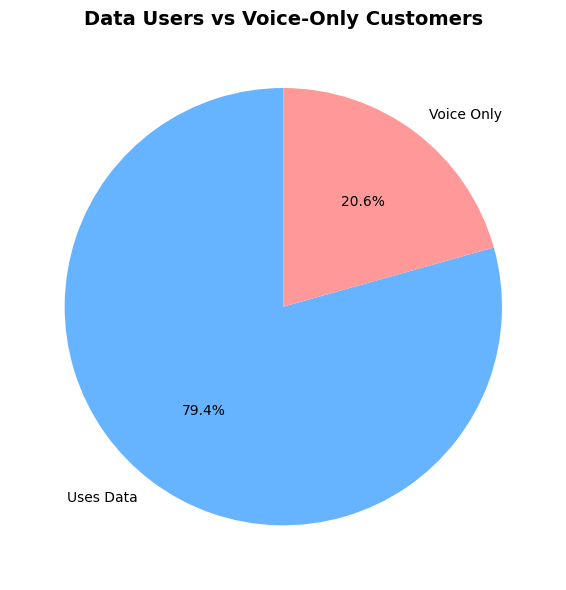

C:\Users\USER\AppData\Local\Temp\ipykernel_30068\3947813849.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


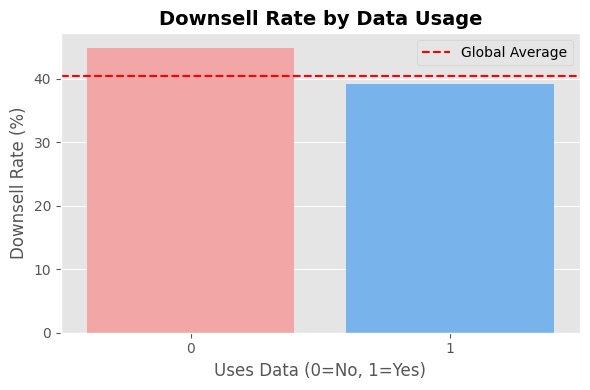

In [439]:
# -------------------------
# Data usage vs Voice-only customers
# -------------------------
data_usage = df_clean['used_data'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    data_usage.values, 
    labels=['Uses Data', 'Voice Only'], 
    autopct='%1.1f%%', 
    colors=['#66b3ff', '#ff9999'], 
    startangle=90
)
plt.title('Data Users vs Voice-Only Customers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -------------------------
# Downsell rate by data usage
# -------------------------
data_down = df_clean.groupby('used_data')['down_sell'].mean() * 100

plt.figure(figsize=(6, 4))
sns.barplot(
    x=[0, 1], 
    y=data_down.values, 
    palette=['#ff9999', '#66b3ff']
)
plt.title('Downsell Rate by Data Usage', fontsize=14, fontweight='bold')
plt.xlabel('Uses Data (0=No, 1=Yes)')
plt.ylabel('Downsell Rate (%)')
plt.axhline(y=df_clean['down_sell'].mean()*100, color='red', linestyle='--', label='Global Average')
plt.legend()
plt.tight_layout()
plt.show()

In [440]:
df.columns

Index(['arpu_m2', 'arpu_voix', 'arpu_data', 'MOU', 'NB_J_REVENU', 'NB_J_VOIX',
       'nb_j_data', 'nb_jr_activite', 'volume_data_in', 'DATE_ACTIVATION',
       'region_administrative', 'handset', 'OM_Montant', 'OM_nb_jr_activite',
       'ID', 'arpu_m3', 'down_sell', 'arpu_m1', 'variation_m1_m2',
       'class_variation_m1_m2', 'seniority_days', 'seniority_class',
       'part_data', 'Call_intensity', 'used_data', 'used_OM', 'is_bi_service',
       'used_voice', 'is_multi_service', 'class_arpu', 'class_data'],
      dtype='object')

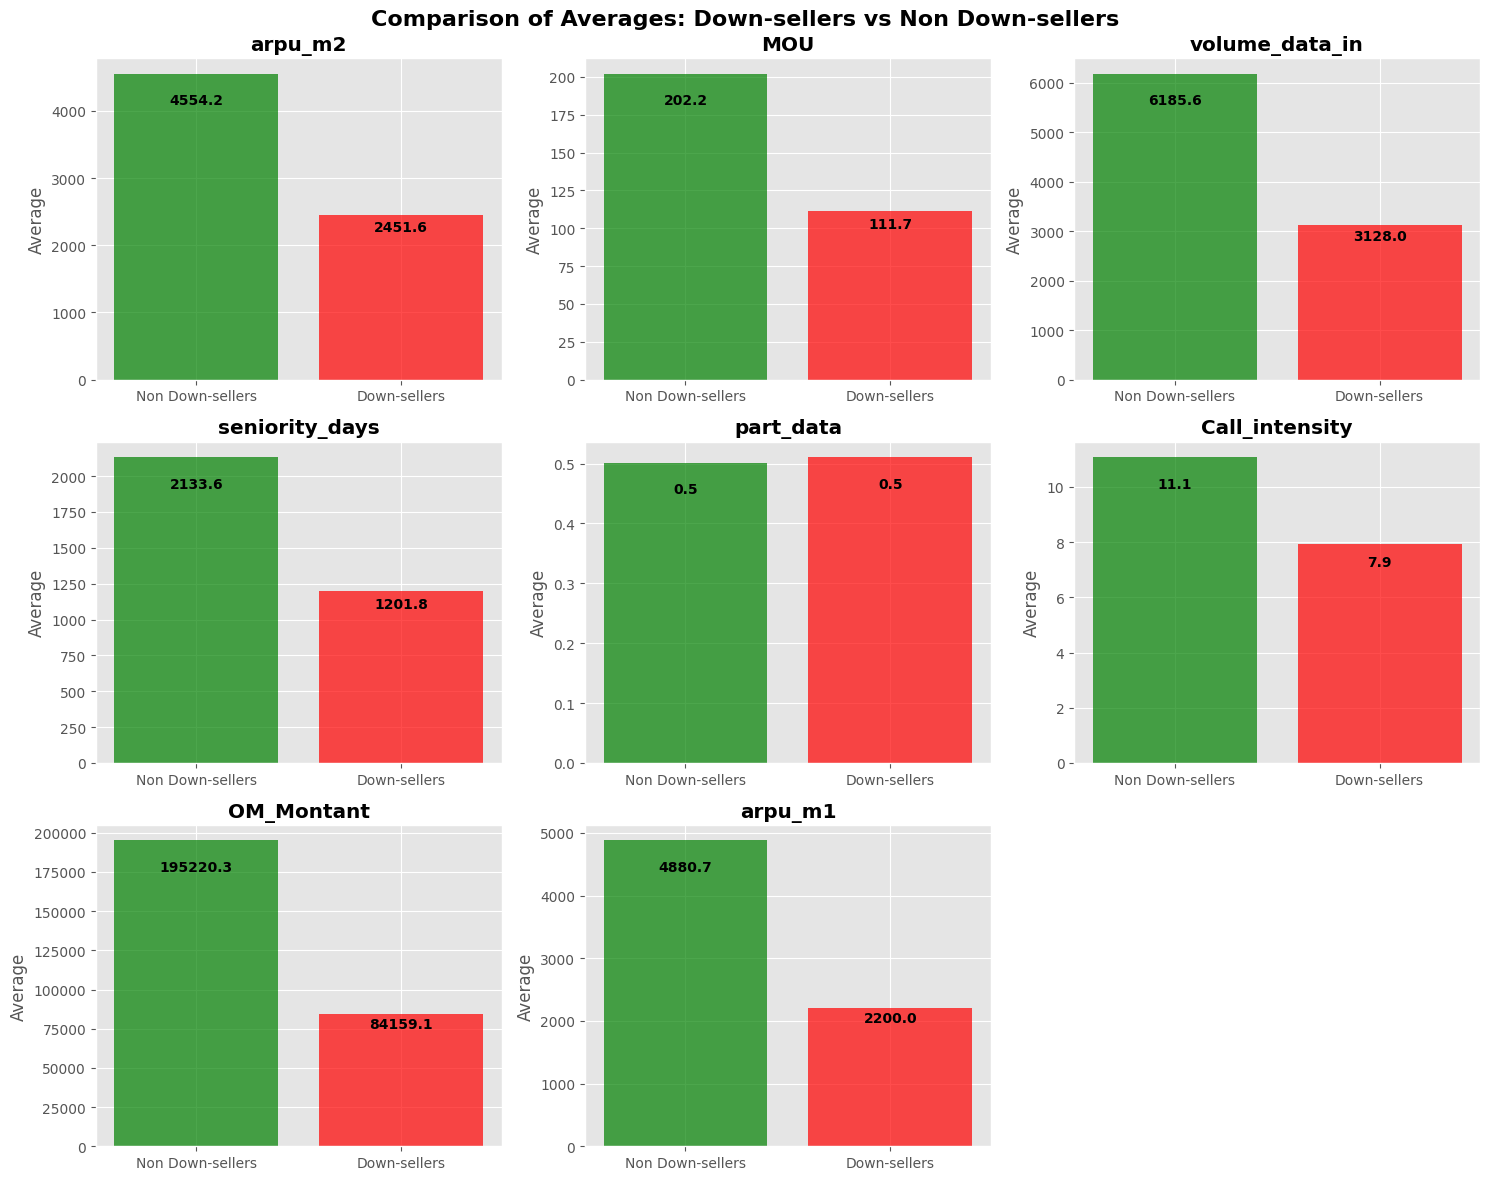

COMPARATIVE TABLE OF MEANS
                Non Down-sellers  Down-sellers
arpu_m2                  4554.19       2451.64
MOU                       202.17        111.66
volume_data_in           6185.59       3127.98
seniority_days           2133.57       1201.75
part_data                   0.50          0.51
Call_intensity             11.08          7.94
OM_Montant             195220.28      84159.09
arpu_m1                  4880.73       2199.99

DIFFERENCES (Down-seller - Non Down-seller):
arpu_m2            -2102.55
MOU                  -90.51
volume_data_in     -3057.61
seniority_days      -931.81
part_data              0.01
Call_intensity        -3.14
OM_Montant       -111061.20
arpu_m1            -2680.73
dtype: float64


In [441]:

# -------------------------
# Key numerical variables
# -------------------------
numeric_vars = [
    'arpu_m2', 'MOU', 'volume_data_in', 'seniority_days', 
    'part_data', 'Call_intensity', 'OM_Montant','arpu_m1'
]

# Compute group means
means = df_clean.groupby('down_sell')[numeric_vars].mean().T
means.columns = ['Non Down-sellers', 'Down-sellers']

# -------------------------
# Bar charts comparison
# -------------------------
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(numeric_vars):
    axes[i].bar(
        ['Non Down-sellers', 'Down-sellers'], 
        means.loc[var].values, 
        color=['green', 'red'], alpha=0.7
    )
    axes[i].set_title(f'{var}', fontweight='bold')
    axes[i].set_ylabel('Average')
    
    # Add value labels on bars
    for j, v in enumerate(means.loc[var].values):
        axes[i].text(j, v*0.9, f'{v:.1f}', ha='center', fontweight='bold')

# Remove 9th subplot if empty
if len(numeric_vars) < 9:
    for j in range(len(numeric_vars), 9):
        fig.delaxes(axes[j])

plt.suptitle(
    'Comparison of Averages: Down-sellers vs Non Down-sellers', 
    fontsize=16, fontweight='bold'
)
plt.tight_layout()
plt.show()

# -------------------------
# Table version
# -------------------------
print("="*60)
print("COMPARATIVE TABLE OF MEANS")
print("="*60)
print(means.round(2))
print("="*60)

# Differences
print("\nDIFFERENCES (Down-seller - Non Down-seller):")
differences = means['Down-sellers'] - means['Non Down-sellers']
print(differences.round(2))

In [442]:
df_clean.columns

Index(['arpu_m2', 'arpu_voix', 'arpu_data', 'MOU', 'NB_J_REVENU', 'NB_J_VOIX',
       'nb_j_data', 'nb_jr_activite', 'volume_data_in', 'DATE_ACTIVATION',
       'region_administrative', 'handset', 'OM_Montant', 'OM_nb_jr_activite',
       'ID', 'arpu_m3', 'down_sell', 'arpu_m1', 'variation_m1_m2',
       'class_variation_m1_m2', 'seniority_days', 'seniority_class',
       'part_data', 'Call_intensity', 'used_data', 'used_OM', 'is_bi_service',
       'used_voice', 'is_multi_service', 'class_arpu', 'class_data',
       'variation'],
      dtype='object')

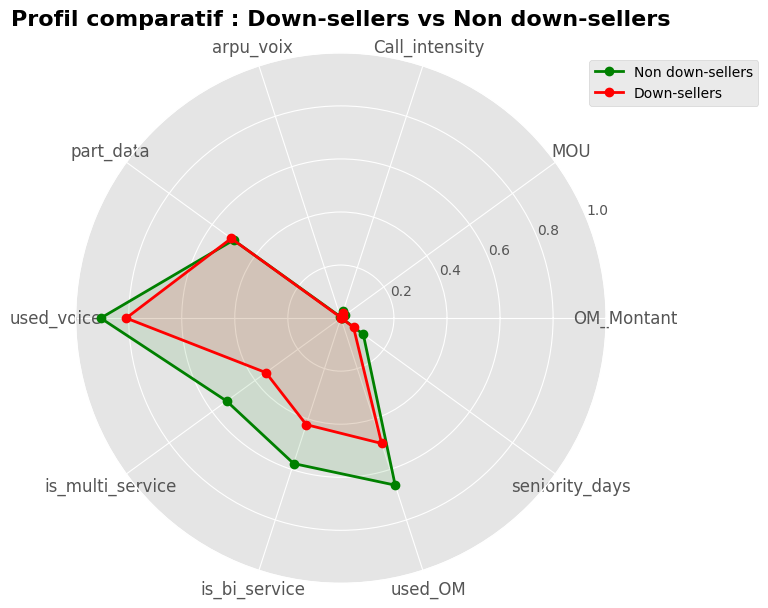


=== PROFIL COMPARATIF (valeurs normalisées) ===
down_sell             0      1
OM_Montant        0.003  0.001
MOU               0.018  0.010
Call_intensity    0.029  0.021
arpu_voix         0.005  0.003
part_data         0.500  0.511
used_voice        0.905  0.809
is_multi_service  0.532  0.350
is_bi_service     0.577  0.422
used_OM           0.662  0.497
seniority_days    0.104  0.059

→ Plus la valeur est proche de 1, plus le groupe est élevé sur cette variable


In [443]:
import numpy as np
from math import pi

# Sélectionner 6 variables clés
variables_radar = ['OM_Montant', 'MOU', 'Call_intensity', 'arpu_voix', 
                   'part_data', 'used_voice','is_multi_service', 'is_bi_service', 'used_OM','seniority_days']

# Normaliser les données (entre 0 et 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_clean[variables_radar]), 
                             columns=variables_radar)
df_normalized['down_sell'] = df_clean['down_sell'].values

# Moyennes par groupe
radar_data = df_normalized.groupby('down_sell')[variables_radar].mean()

# Préparation du radar
categories = variables_radar
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # fermer le cercle

# Initialisation
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Ajouter les deux profils
values_stable = radar_data.loc[0].values.tolist()
values_stable += values_stable[:1]
ax.plot(angles, values_stable, 'o-', linewidth=2, color='green', label='Non down-sellers')
ax.fill(angles, values_stable, alpha=0.1, color='green')

values_down = radar_data.loc[1].values.tolist()
values_down += values_down[:1]
ax.plot(angles, values_down, 'o-', linewidth=2, color='red', label='Down-sellers')
ax.fill(angles, values_down, alpha=0.1, color='red')

# Personnalisation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Profil comparatif : Down-sellers vs Non down-sellers', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

# Version plus simple à interpréter
print("\n=== PROFIL COMPARATIF (valeurs normalisées) ===")
print(radar_data.T.round(3))
print("\n→ Plus la valeur est proche de 1, plus le groupe est élevé sur cette variable")

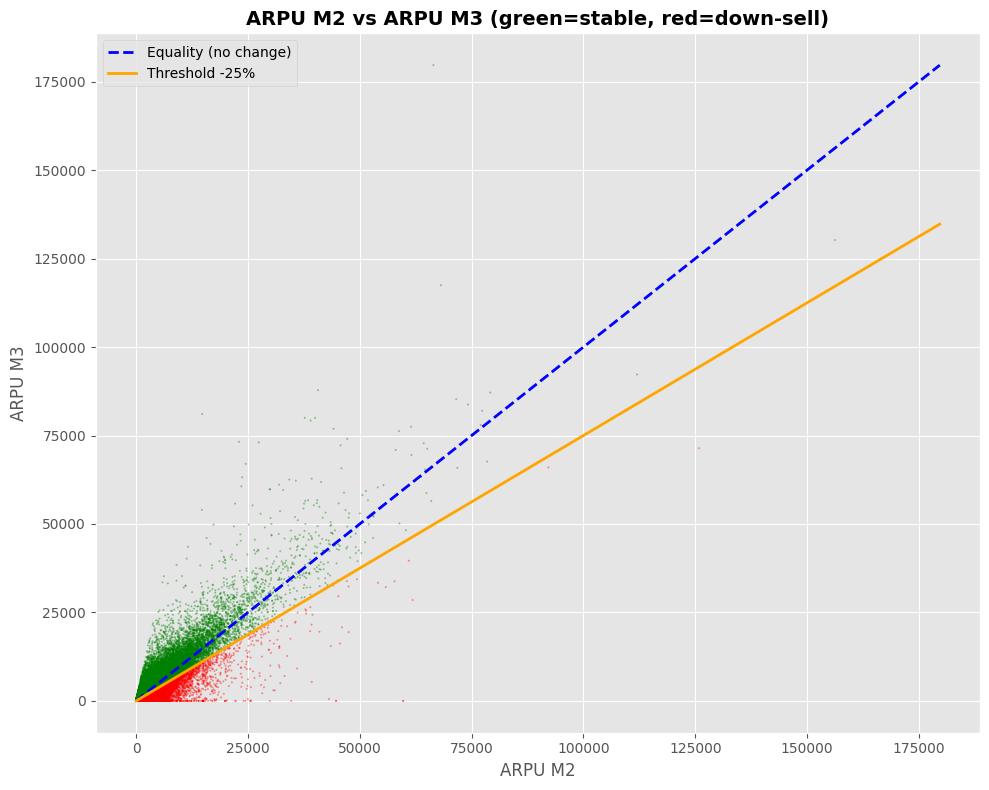

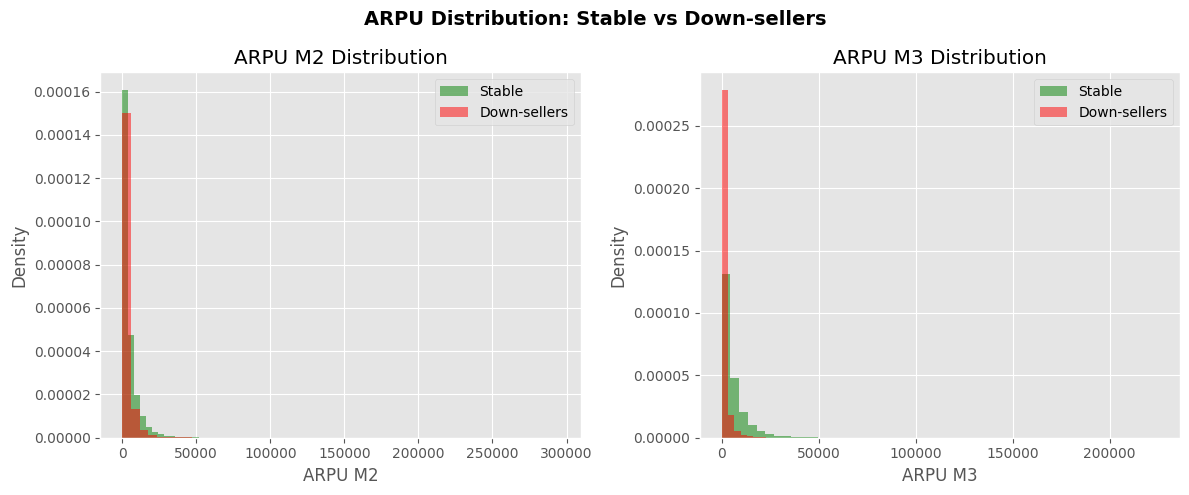

In [444]:
# Scatter plot (sample to avoid over-plotting)
sample = df_clean.sample(min(50000, len(df_clean)))

plt.figure(figsize=(10, 8))
colors = sample['down_sell'].map({0: 'green', 1: 'red'})
plt.scatter(sample['arpu_m2'], sample['arpu_m3'], c=colors, alpha=0.3, s=1)

# Reference lines
max_val = max(sample['arpu_m2'].max(), sample['arpu_m3'].max())
plt.plot([0, max_val], [0, max_val], 'b--', linewidth=2, label='Equality (no change)')
plt.plot([0, max_val], [0, 0.75*max_val], 'orange', linewidth=2, label='Threshold -25%')

plt.xlabel('ARPU M2')
plt.ylabel('ARPU M3')
plt.title('ARPU M2 vs ARPU M3 (green=stable, red=down-sell)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

# Overlapping distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean[df_clean['down_sell']==0]['arpu_m2'], bins=50, alpha=0.5, label='Stable', color='green', density=True)
plt.hist(df_clean[df_clean['down_sell']==1]['arpu_m2'], bins=50, alpha=0.5, label='Down-sellers', color='red', density=True)
plt.xlabel('ARPU M2')
plt.ylabel('Density')
plt.title('ARPU M2 Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_clean[df_clean['down_sell']==0]['arpu_m3'], bins=50, alpha=0.5, label='Stable', color='green', density=True)
plt.hist(df_clean[df_clean['down_sell']==1]['arpu_m3'], bins=50, alpha=0.5, label='Down-sellers', color='red', density=True)
plt.xlabel('ARPU M3')
plt.ylabel('Density')
plt.title('ARPU M3 Distribution')
plt.legend()

plt.suptitle('ARPU Distribution: Stable vs Down-sellers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [445]:
# region rate
verif = df.groupby('region_administrative')['down_sell'].mean().sort_values(ascending=False) * 100
print(verif.head(10))

region_administrative
Unknown         90.812934
NORD-OUEST      77.143642
SUD-OUEST       74.446875
ADAMAOUA        61.188969
LITTORAL        53.852630
OUEST           53.640040
EST             52.027251
EXTREME-NORD    51.037552
NORD            48.375873
CENTRE          47.980583
Name: down_sell, dtype: float64


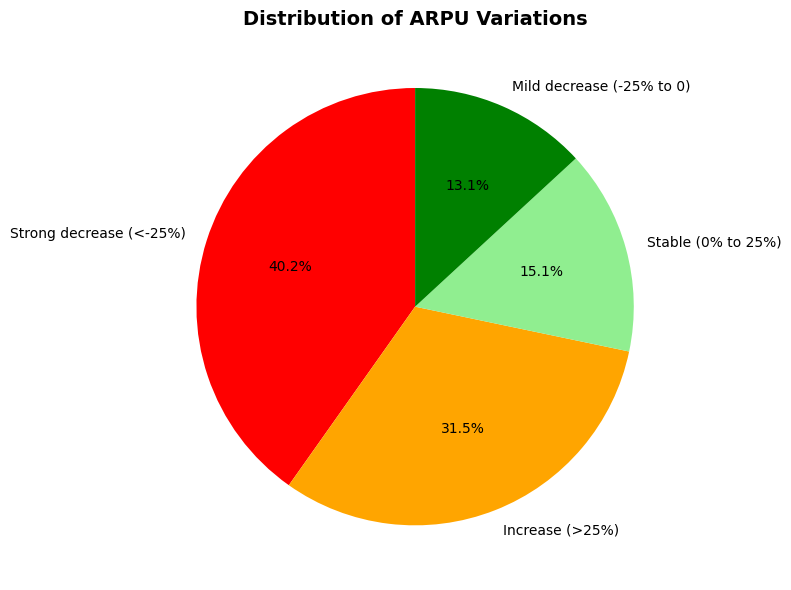

=== VARIATION STATISTICS ===
Median: -6.1%
Mean: 5.9%
% decreasing (any decrease): 53.3%
% strong decrease (our target): 40.2%


In [446]:
# Calculate variations if not already done
if 'variation' not in df_clean.columns:
    df_clean['variation'] = (df_clean['arpu_m3'] - df_clean['arpu_m2']) / df_clean['arpu_m2']

# Categorize variations
def categorize_variation(x):
    if x < -0.25:
        return 'Strong decrease (<-25%)'
    elif x < 0:
        return 'Mild decrease (-25% to 0)'
    elif x < 0.25:
        return 'Stable (0% to 25%)'
    else:
        return 'Increase (>25%)'

df_clean['variation_category'] = df_clean['variation'].apply(categorize_variation)

# Plot
plt.figure(figsize=(10, 6))
category_counts = df_clean['variation_category'].value_counts()
colors = ['red', 'orange', 'lightgreen', 'green']
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of ARPU Variations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print stats
print("=== VARIATION STATISTICS ===")
print(f"Median: {df_clean['variation'].median()*100:.1f}%")
print(f"Mean: {df_clean['variation'].mean()*100:.1f}%")
print(f"% decreasing (any decrease): {(df_clean['variation'] < 0).mean()*100:.1f}%")
print(f"% strong decrease (our target): {(df_clean['variation'] < -0.25).mean()*100:.1f}%")

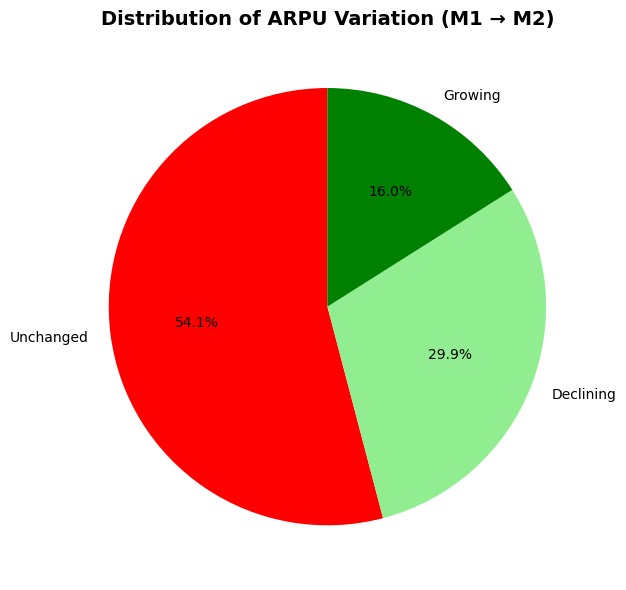


ARPU VARIATION SUMMARY
Unchanged  :    734,792 clients (54.1%)
Declining  :    405,809 clients (29.9%)
Growing    :    217,743 clients (16.0%)


In [447]:
import matplotlib.pyplot as plt

# Count per variation class
variation_counts = df['class_variation_m1_m2'].value_counts()

# Colors for the classes
colors = ['red', 'lightgreen', 'green', 'gray']  # Declining, Unchanged, Growing, Unknown

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(variation_counts.values, 
        labels=variation_counts.index, 
        autopct='%1.1f%%', 
        colors=colors[:len(variation_counts)], 
        startangle=90)
plt.title('Distribution of ARPU Variation (M1 → M2)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("ARPU VARIATION SUMMARY")
print("="*60)
for cls in variation_counts.index:
    print(f"{cls:<10} : {variation_counts[cls]:>10,} clients ({variation_counts[cls]/len(df)*100:.1f}%)")

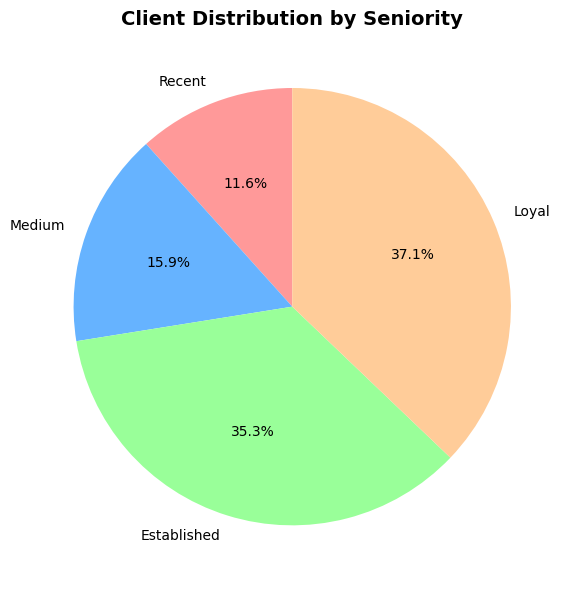


CLIENT DISTRIBUTION BY SENIORITY (excluding Unknowned)
Recent       :    157,711 clients (11.6%)
Medium       :    214,915 clients (15.8%)
Established  :    478,419 clients (35.2%)
Loyal        :    502,707 clients (37.0%)


In [448]:
import matplotlib.pyplot as plt

# Filter out "Unknowned"
seniority_counts = df[df["seniority_class"] != "Unknowned"]["seniority_class"].value_counts()

# Optional: reorder the categories
ordered_classes = ["Recent", "Medium", "Established", "Loyal"]
seniority_counts = seniority_counts.reindex(ordered_classes).dropna()

# Colors for the classes
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    seniority_counts.values, 
    labels=seniority_counts.index, 
    autopct='%1.1f%%', 
    colors=colors[:len(seniority_counts)], 
    startangle=90
)
plt.title('Client Distribution by Seniority', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*60)
print("CLIENT DISTRIBUTION BY SENIORITY (excluding Unknowned)")
print("="*60)
for cls in seniority_counts.index:
    print(f"{cls:<12} : {seniority_counts[cls]:>10,} clients ({seniority_counts[cls]/len(df)*100:.1f}%)")

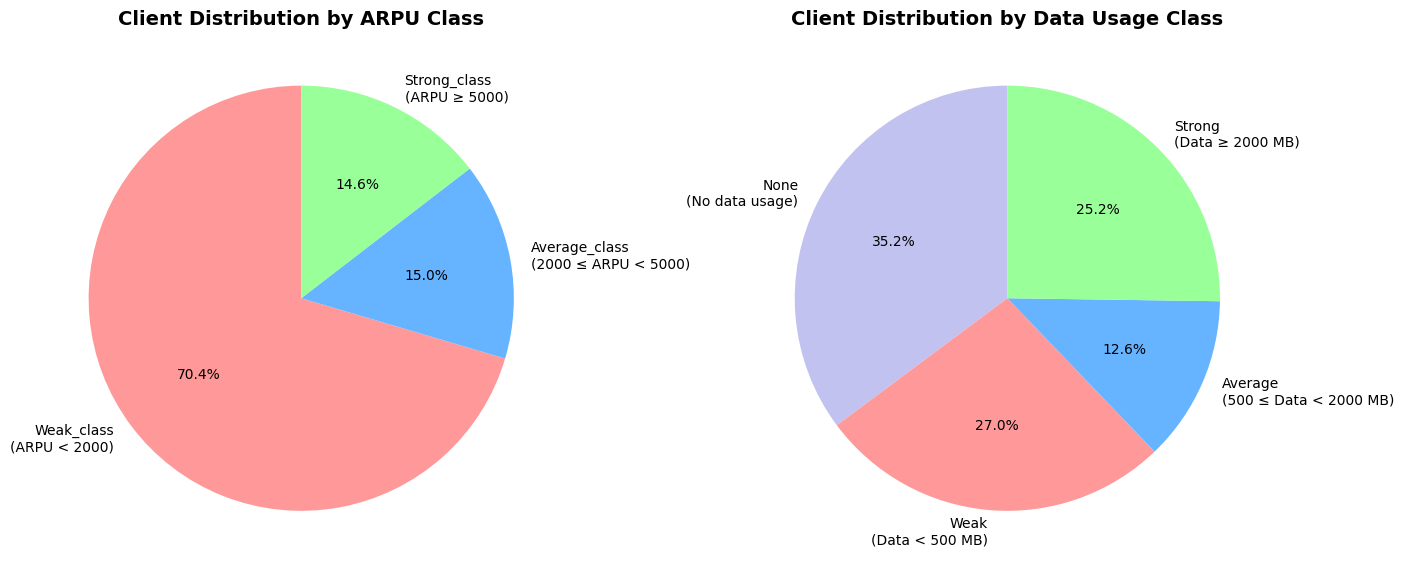


CLIENT DISTRIBUTION BY ARPU CLASS
Weak_class      (ARPU < 2000    ) :    956,595 clients (70.4%)
Average_class   (2000 ≤ ARPU < 5000) :    203,973 clients (15.0%)
Strong_class    (ARPU ≥ 5000    ) :    197,776 clients (14.6%)

CLIENT DISTRIBUTION BY DATA CLASS
None            (No data usage  ) :    478,021 clients (35.2%)
Weak            (Data < 500 MB  ) :    366,560 clients (27.0%)
Average         (500 ≤ Data < 2000 MB) :    171,130 clients (12.6%)
Strong          (Data ≥ 2000 MB ) :    342,633 clients (25.2%)


In [449]:

# Definitions
arpu_definitions = {
    "Weak_class": "ARPU < 2000",
    "Average_class": "2000 ≤ ARPU < 5000",
    "Strong_class": "ARPU ≥ 5000"
}

data_definitions = {
    "None": "No data usage",
    "Weak": "Data < 500 MB",
    "Average": "500 ≤ Data < 2000 MB",
    "Strong": "Data ≥ 2000 MB"
}


# Counts

arpu_counts = df["class_arpu"].value_counts().reindex(["Weak_class", "Average_class", "Strong_class"])
data_counts = df["class_data"].value_counts().reindex(["None", "Weak", "Average", "Strong"])

# Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ARPU
colors_arpu = ['#ff9999', '#66b3ff', '#99ff99']
labels_arpu = [f"{cls}\n({arpu_definitions[cls]})" for cls in arpu_counts.index]
axes[0].pie(arpu_counts.values, labels=labels_arpu, autopct='%1.1f%%', colors=colors_arpu, startangle=90)
axes[0].set_title("Client Distribution by ARPU Class", fontsize=14, fontweight='bold')

# Data
colors_data = ['#c2c2f0', '#ff9999', '#66b3ff', '#99ff99']
labels_data = [f"{cls}\n({data_definitions[cls]})" for cls in data_counts.index]
axes[1].pie(data_counts.values, labels=labels_data, autopct='%1.1f%%', colors=colors_data, startangle=90)
axes[1].set_title("Client Distribution by Data Usage Class", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# -------------------------
# Summary Tables
# -------------------------
print("\n" + "="*60)
print("CLIENT DISTRIBUTION BY ARPU CLASS")
print("="*60)
for cls in arpu_counts.index:
    print(f"{cls:<15} ({arpu_definitions[cls]:<15}) : {arpu_counts[cls]:>10,} clients ({arpu_counts[cls]/len(df)*100:.1f}%)")

print("\n" + "="*60)
print("CLIENT DISTRIBUTION BY DATA CLASS")
print("="*60)
for cls in data_counts.index:
    print(f"{cls:<15} ({data_definitions[cls]:<15}) : {data_counts[cls]:>10,} clients ({data_counts[cls]/len(df)*100:.1f}%)")

In [450]:
# Select categorical columns (object or category dtype)
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Also include numeric columns that behave like categorical (low unique values)
numeric_categorical = [
    col for col in df_clean.select_dtypes(include=['int64', 'float64']).columns
    if df_clean[col].nunique() < 10  # threshold can be adjusted
]

# Combine both
all_categorical = list(set(categorical_cols + numeric_categorical))

# Remove binary columns (only 2 unique values like 0/1)
non_binary_categorical = [
    col for col in all_categorical
    if df_clean[col].nunique() > 2
]

print("Categorical variables (excluding binary):")
print(non_binary_categorical)

Categorical variables (excluding binary):
['seniority_class', 'handset', 'class_arpu', 'region_administrative', 'class_data', 'class_variation_m1_m2', 'variation_category']


In [451]:
# List of categorical variables to encode
categorical_vars = [
    'seniority_class',
    'handset',
    'class_arpu',
    'region_administrative',
    'class_data',
    'class_variation_m1_m2',
    'variation_category'
]

# Target Encoding using down_sell mean
for col in categorical_vars:
    df_clean[col + "_enc"] = df_clean.groupby(col)['down_sell'].transform('mean')


In [452]:
col = [
    'arpu_m2', 'arpu_voix', 'arpu_data', 'MOU', 'NB_J_REVENU', 'NB_J_VOIX',
    'nb_j_data', 'nb_jr_activite', 'volume_data_in',
    'OM_Montant', 'OM_nb_jr_activite', 'down_sell', 'arpu_m1',
    'variation_m1_m2', 'seniority_days', 'part_data', 'Call_intensity',
    'used_data', 'used_OM', 'is_bi_service', 'used_voice',
    'is_multi_service', 'seniority_class_enc', 'handset_enc',
    'class_arpu_enc', 'region_administrative_enc', 'class_data_enc',
    'class_variation_m1_m2_enc', 'variation_category_enc'
]
# i took away variation

In [460]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 857141 entries, 1 to 1358343
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   arpu_m2                    857141 non-null  float64       
 1   arpu_voix                  857141 non-null  float64       
 2   arpu_data                  857141 non-null  float64       
 3   MOU                        857141 non-null  float64       
 4   NB_J_REVENU                857141 non-null  float64       
 5   NB_J_VOIX                  857141 non-null  float64       
 6   nb_j_data                  857141 non-null  float64       
 7   nb_jr_activite             857141 non-null  float64       
 8   volume_data_in             857141 non-null  float64       
 9   DATE_ACTIVATION            857141 non-null  datetime64[ns]
 10  region_administrative      857141 non-null  object        
 11  handset                    857141 non-null  object      

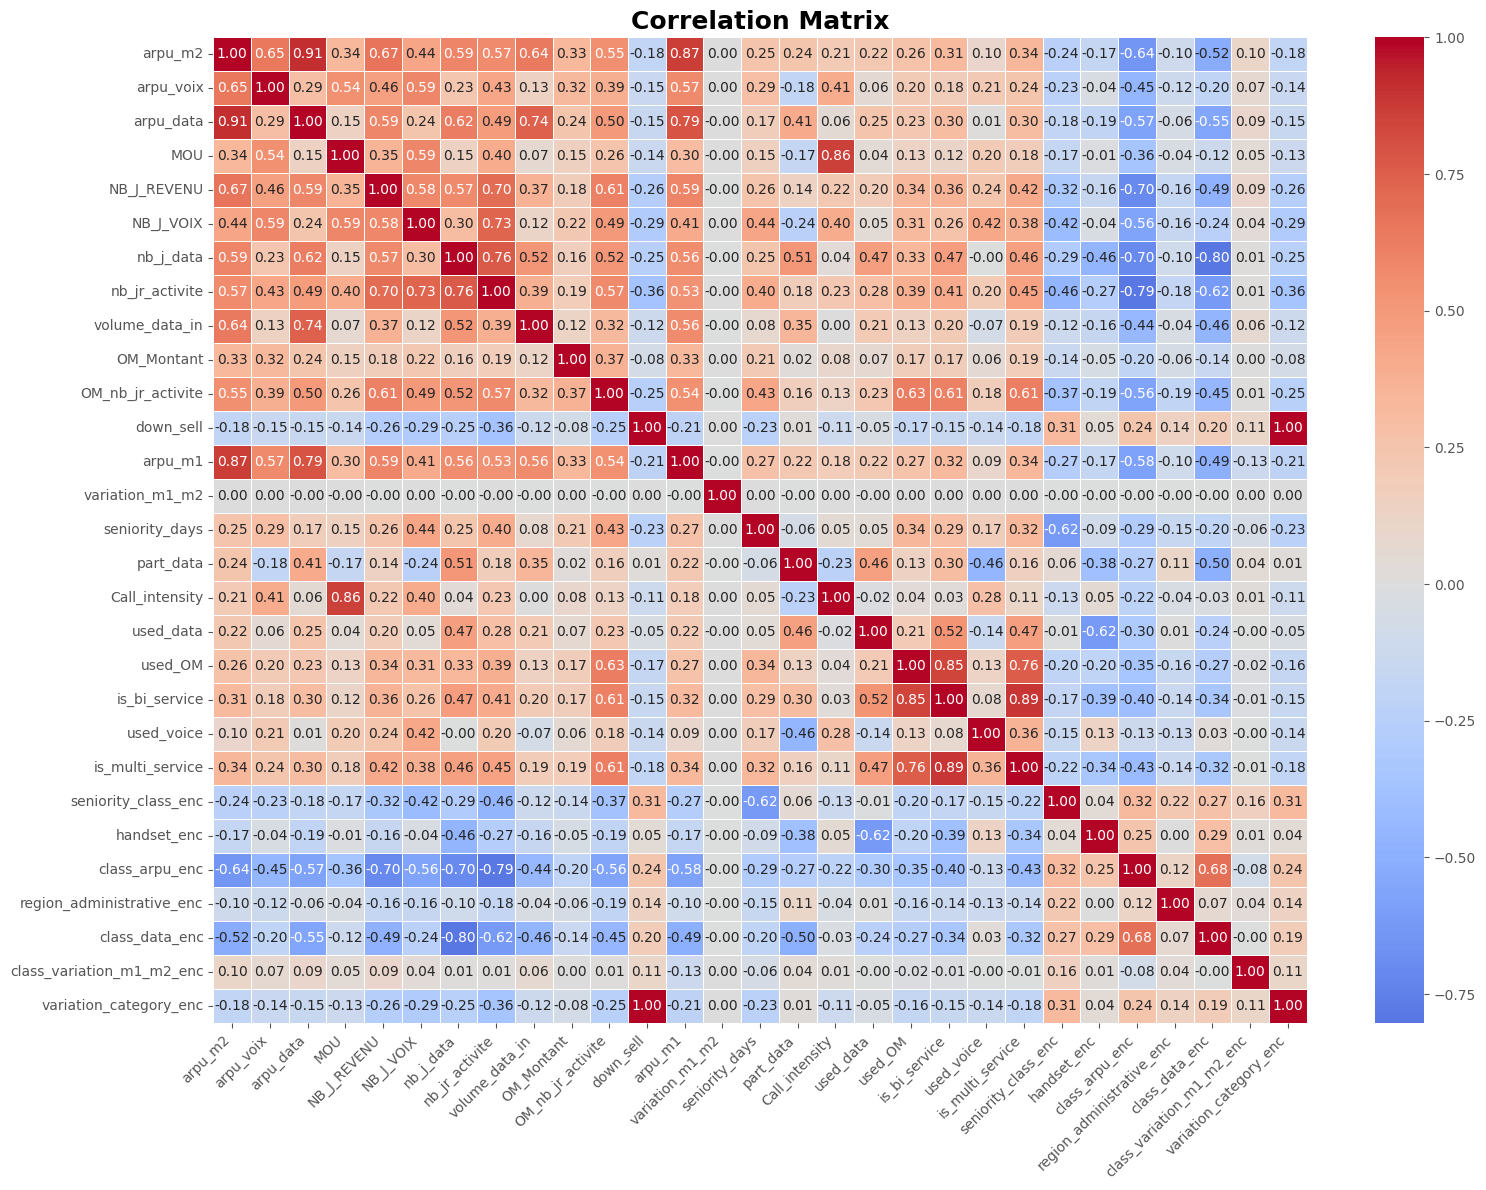

In [453]:

# Select only numeric columns from your list (safety check)
numeric_cols = [c for c in col if df_clean[c].dtype != 'object']

# Compute correlation matrix
corr_matrix = df_clean[numeric_cols].corr()

# Plot
plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    annot=True,              # show correlation values
    fmt=".2f",               # 2 decimals
    cmap="coolwarm",         # color gradient
    center=0,                # center color at 0
    linewidths=0.5
)

plt.title("Correlation Matrix", fontsize=18, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [454]:
col_keep = [
    # ===== Financial (Month 2 only) =====
    "arpu_m2",
    "arpu_voix",
    
    # ===== Usage behavior =====
    "MOU",
    "nb_j_data",
    "volume_data_in",
    "nb_jr_activite",
    
    # ===== Mobile Money behavior =====
    "OM_Montant",
    "OM_nb_jr_activite",
    
    # ===== Service engagement =====
    "used_data",
    "used_voice",
    "is_multi_service",
    'nb_j_data','NB_J_VOIX',
    
    # ===== Customer profile =====
    "seniority_days",
    "handset_enc",
    "region_administrative_enc",
    
    # ===== Encoded business classes (not redundant) =====
    "class_arpu_enc",
    "seniority_class_enc",
    
    # ===== Behavioral trend (VERY IMPORTANT) =====
    "variation_m1_m2"
]

In [378]:
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

In [463]:
# APRÈS votre train_test_split

# Tailles brutes
print(f"Taille de X_train: {len(X_train)} clients")
print(f"Taille de X_test: {len(X_test)} clients")
print(f"Taille totale: {len(X_train) + len(X_test)} clients")
print()

# Vérification avec y
print(f"Taille de y_train: {len(y_train)}")
print(f"Taille de y_test: {len(y_test)}")
print(f"Taille totale (y): {len(y_train) + len(y_test)}")
print()

# Taux de down-sell
print(f"Taux down-sell dans train: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
print(f"Taux down-sell dans test: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
print()

# Vérification du split (si vous avez utilisé stratify)
print(f"Proportion train: {len(X_train)/(len(X_train)+len(X_test))*100:.2f}%")
print(f"Proportion test: {len(X_test)/(len(X_train)+len(X_test))*100:.2f}%")

Taille de X_train: 685712 clients
Taille de X_test: 171429 clients
Taille totale: 857141 clients

Taille de y_train: 685712
Taille de y_test: 171429
Taille totale (y): 857141

Taux down-sell dans train: 0.4041 (40.41%)
Taux down-sell dans test: 0.4041 (40.41%)

Proportion train: 80.00%
Proportion test: 20.00%


In [382]:

# MODÈLE 1 : RÉGRESSION LOGISTIQUE (col_keep)

print("  MODL 1 : Logistic regression (col_keep)")


# Features / Target

X = df_clean[col_keep]
y = df_clean['down_sell']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardization
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


#  configuration)

lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    C=0.5,
    random_state=42
)

lr.fit(X_train_sc, y_train)

# Predictions
y_pred_lr  = lr.predict(X_test_sc)
y_proba_lr = lr.predict_proba(X_test_sc)[:, 1]

# Metrics
auc_lr  = roc_auc_score(y_test, y_proba_lr)
f1_lr   = f1_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr  = recall_score(y_test, y_pred_lr)

print(f"AUC        : {auc_lr:.4f}")
print(f"F1-Score   : {f1_lr:.4f}")
print(f"Précision  : {prec_lr:.4f}")
print(f"Rappel     : {rec_lr:.4f}")
print("\n")
print(classification_report(
    y_test, 
    y_pred_lr, 
    target_names=['Non down-sell', 'Down_sell']
))

  MODL 1 : Logistic regression (col_keep)
AUC        : 0.7321
F1-Score   : 0.6155
Précision  : 0.5793
Rappel     : 0.6565


               precision    recall  f1-score   support

Non down-sell       0.75      0.68      0.71    153516
    Down_sell       0.58      0.66      0.62    103627

     accuracy                           0.67    257143
    macro avg       0.66      0.67      0.66    257143
 weighted avg       0.68      0.67      0.67    257143



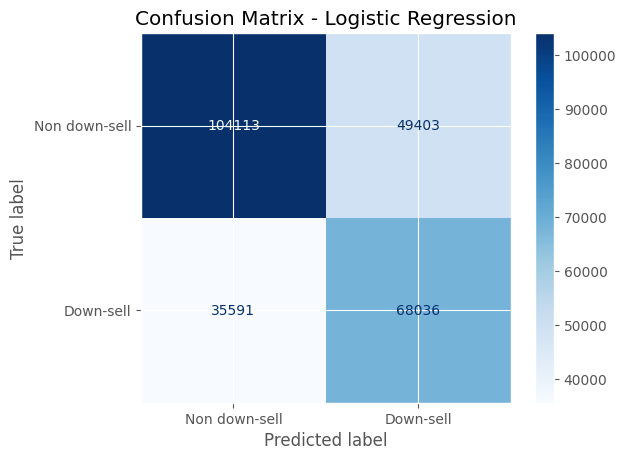

In [380]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non down-sell', 'Down-sell'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Top features par importance :
                      feature  coefficient  odds_ratio  importance_%
5              nb_jr_activite       -0.635       0.530        31.221
17        seniority_class_enc        0.342       1.408        16.817
16             class_arpu_enc       -0.218       0.804        10.707
7           OM_nb_jr_activite       -0.150       0.861         7.354
15  region_administrative_enc        0.098       1.103         4.798
9                  used_voice       -0.097       0.907         4.775
12                  NB_J_VOIX       -0.085       0.919         4.161
4              volume_data_in       -0.078       0.925         3.845
0                     arpu_m2        0.076       1.079         3.722
14                handset_enc       -0.067       0.935         3.285
11                  nb_j_data       -0.041       0.960         2.018
3                   nb_j_data       -0.041       0.960         2.018
1                   arpu_voix        0.034       1.035         1.669
8  

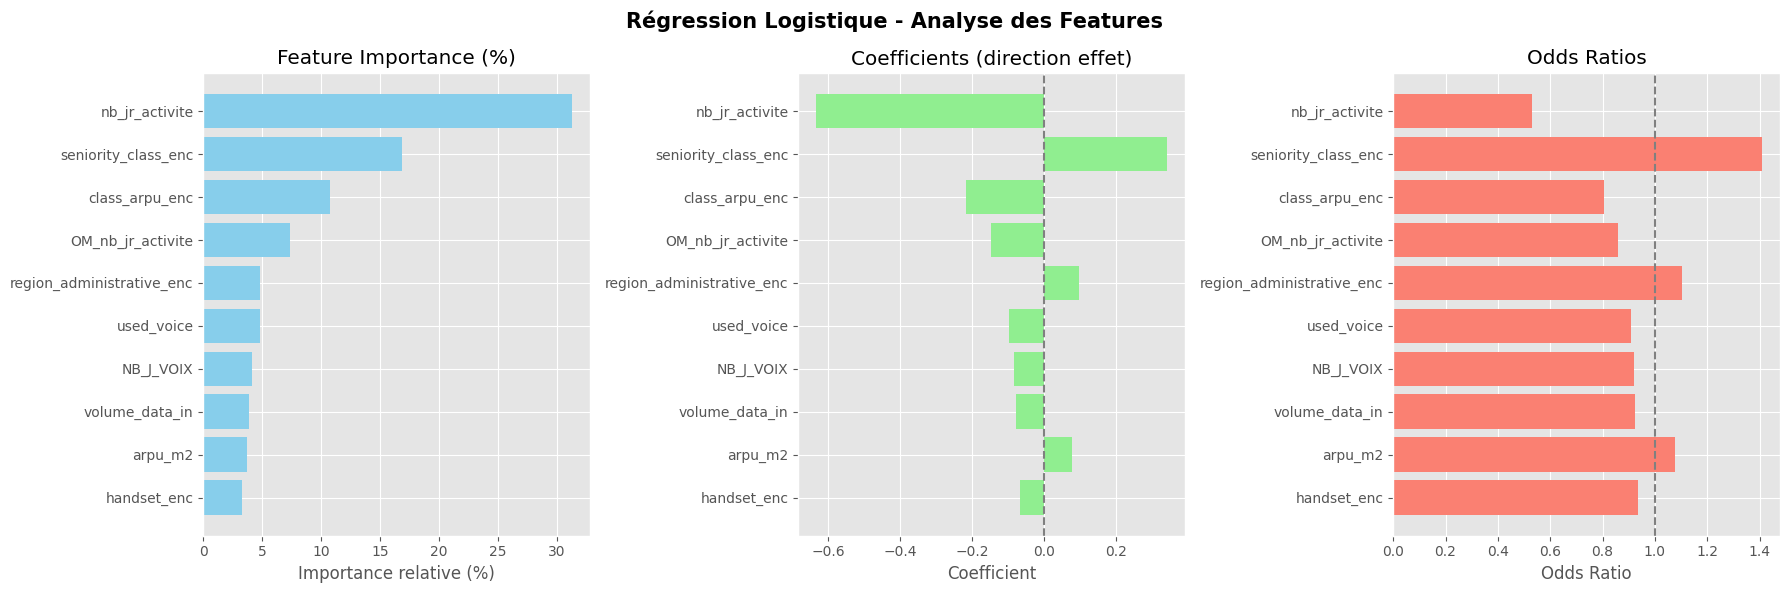

In [383]:

# LOGISTIC REGRESSION FEATURE IMPORTANCE (col_keep)

from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Features and target
X = df_clean[col_keep]
y = df_clean['down_sell']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


# Logistic Regression

lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='lbfgs',
    C=0.5,
    random_state=42
)
lr.fit(X_train_sc, y_train)

# Predictions
y_pred_lr  = lr.predict(X_test_sc)
y_proba_lr = lr.predict_proba(X_test_sc)[:, 1]


# Feature importance

coefs = lr.coef_[0]
odds_ratios = np.exp(coefs)
importance_pct = np.abs(coefs) / np.sum(np.abs(coefs)) * 100

lr_importance = pd.DataFrame({
    'feature': col_keep,
    'coefficient': coefs,
    'odds_ratio': odds_ratios,
    'importance_%': importance_pct
}).sort_values('importance_%', ascending=False)

print("\nTop features par importance :")
print(lr_importance.round(3))


# Plot top 10 features

top_n = 10
data_plot = lr_importance.head(top_n)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1️⃣ Importance %
axes[0].barh(data_plot['feature'], data_plot['importance_%'], color='skyblue')
axes[0].set_xlabel('Importance relative (%)')
axes[0].set_title('Feature Importance (%)')
axes[0].invert_yaxis()

# 2️⃣ Coefficients
axes[1].barh(data_plot['feature'], data_plot['coefficient'], color='lightgreen')
axes[1].axvline(x=0, linestyle='--', color='gray')
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Coefficients (direction effet)')
axes[1].invert_yaxis()

# 3️⃣ Odds Ratios
axes[2].barh(data_plot['feature'], data_plot['odds_ratio'], color='salmon')
axes[2].axvline(x=1, linestyle='--', color='gray')
axes[2].set_xlabel('Odds Ratio')
axes[2].set_title('Odds Ratios')
axes[2].invert_yaxis()

plt.suptitle('Régression Logistique - Analyse des Features', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

  MODÈLE 2 : Random Forest
AUC        : 0.7624
F1-Score   : 0.6307
Précision  : 0.6155
Rappel     : 0.6468

               precision    recall  f1-score   support

Non down-sell       0.75      0.73      0.74    102159
    Down-sell       0.62      0.65      0.63     69270

     accuracy                           0.69    171429
    macro avg       0.68      0.69      0.68    171429
 weighted avg       0.70      0.69      0.70    171429



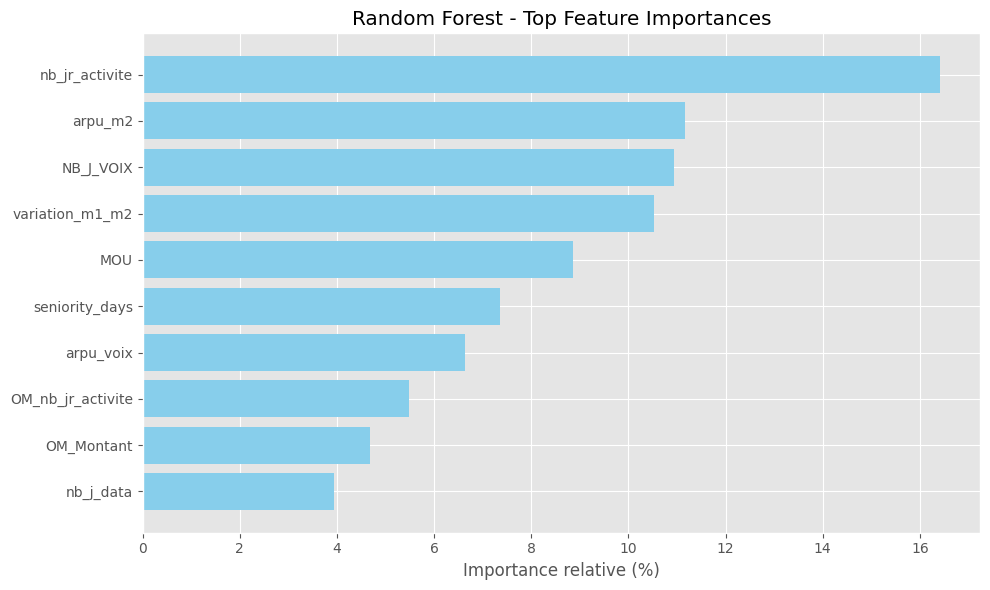


Top features:
                      feature  importance_%
5              nb_jr_activite        16.418
0                     arpu_m2        11.160
12                  NB_J_VOIX        10.935
18            variation_m1_m2        10.528
2                         MOU         8.861
13             seniority_days         7.356
1                   arpu_voix         6.630
7           OM_nb_jr_activite         5.492
6                  OM_Montant         4.673
3                   nb_j_data         3.944
11                  nb_j_data         3.766
17        seniority_class_enc         3.652
4              volume_data_in         3.165
15  region_administrative_enc         1.252
16             class_arpu_enc         0.831
10           is_multi_service         0.625
14                handset_enc         0.407
9                  used_voice         0.206
8                   used_data         0.099


In [384]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report


# Features and target

X = df_clean[col_keep]   # use the same features as before
y = df_clean['down_sell']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Random Forest

print("=" * 50)
print("  MODÈLE 2 : Random Forest")
print("=" * 50)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=20,
    min_samples_split=15,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
auc_rf  = roc_auc_score(y_test, y_proba_rf)
f1_rf   = f1_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)

print(f"AUC        : {auc_rf:.4f}")
print(f"F1-Score   : {f1_rf:.4f}")
print(f"Précision  : {prec_rf:.4f}")
print(f"Rappel     : {rec_rf:.4f}")
print(f"\n{classification_report(y_test, y_pred_rf, target_names=['Non down-sell', 'Down-sell'])}")

# Feature Importance

importances = rf.feature_importances_
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance_%': importances * 100
}).sort_values('importance_%', ascending=False)

# Display top 10
top_n = 10
data_plot = rf_importance.head(top_n)

plt.figure(figsize=(10,6))
plt.barh(data_plot['feature'], data_plot['importance_%'], color='skyblue')
plt.xlabel('Importance relative (%)')
plt.title('Random Forest - Top Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop features:")
print(rf_importance.round(3))

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report

try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    XGBOOST_AVAILABLE = False


# Target

y = df_clean['down_sell']


# Train/test split first

X_train, X_test, y_train, y_test = train_test_split(
    df_clean.copy(), y, test_size=0.2, random_state=42, stratify=y
)


# Categorical columns to target encode

cat_vars = ['seniority_class', 'handset', 'class_arpu', 'region_administrative',
            'class_data', 'class_variation_m1_m2', 'variation_category']

for col in cat_vars:
    mapping = X_train.groupby(col)['down_sell'].mean()
    X_train[col + '_enc'] = X_train[col].map(mapping)
    X_test[col + '_enc']  = X_test[col].map(mapping).fillna(mapping.mean())


# Keep only selected features

col_keep = [
    "arpu_m2", "arpu_voix",
    "MOU", "nb_j_data", "volume_data_in", "nb_jr_activite",
    "OM_Montant", "OM_nb_jr_activite",
    "used_data", "used_voice", "is_multi_service", "NB_J_VOIX",
    "seniority_days", "handset_enc", "region_administrative_enc",
    "class_arpu_enc", "seniority_class_enc",
    "variation_m1_m2"
]

X_train_final = X_train[col_keep].copy()
X_test_final  = X_test[col_keep].copy()


# Convert all columns to float64 (avoid XGBoost dtype issues)

X_train_final = X_train_final.astype(np.float64)
X_test_final  = X_test_final.astype(np.float64)


# Handle class imbalance for XGBoost

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


# XGBoost / GradientBoosting

if XGBOOST_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=15,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=2.0,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
else:
    from sklearn.ensemble import GradientBoostingClassifier
    xgb = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )

# Fit model

xgb.fit(X_train_final, y_train)


# Predictions and metrics

y_pred_xgb  = xgb.predict(X_test_final)
y_proba_xgb = xgb.predict_proba(X_test_final)[:, 1]

print("=== XGBoost / GradientBoosting ===")
print(f"AUC      : {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"F1       : {f1_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_xgb):.4f}")
print("\n" + classification_report(y_test, y_pred_xgb, target_names=['Non down-sell', 'Down-sell']))

=== XGBoost / GradientBoosting ===
AUC      : 0.7642
F1       : 0.6351
Precision: 0.6105
Recall   : 0.6619

               precision    recall  f1-score   support

Non down-sell       0.76      0.71      0.73    102159
    Down-sell       0.61      0.66      0.64     69270

     accuracy                           0.69    171429
    macro avg       0.68      0.69      0.68    171429
 weighted avg       0.70      0.69      0.69    171429



In [410]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

# Predictions
y_train_pred  = xgb.predict(X_train_final)
y_train_proba = xgb.predict_proba(X_train_final)[:, 1]

y_test_pred   = y_pred_xgb
y_test_proba  = y_proba_xgb

# Metrics dictionary
metrics = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    'Recall': [
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)
    ],
    'F1-score': [
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_train, y_train_proba),
        roc_auc_score(y_test, y_test_proba)
    ]
}

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metrics)
metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']] = metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']].applymap(lambda x: f"{x:.4f}")
print(metrics_df)

  Dataset Accuracy  Recall F1-score ROC-AUC
0   Train   0.6995  0.6674   0.6422  0.7719
1    Test   0.6927  0.6619   0.6351  0.7642


C:\Users\USER\AppData\Local\Temp\ipykernel_30068\3960356358.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']] = metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']].applymap(lambda x: f"{x:.4f}")


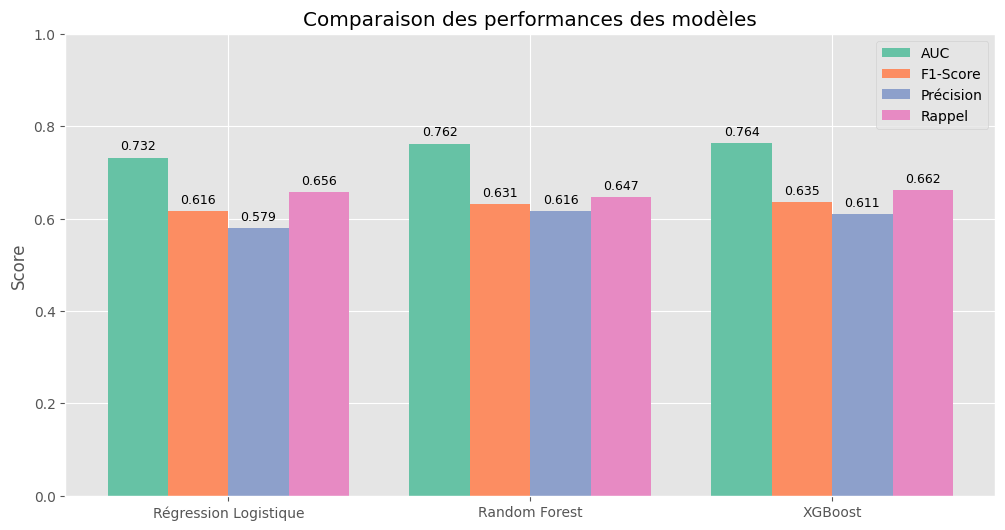

In [390]:

# Data
models = ['Régression Logistique', 'Random Forest', 'XGBoost']

auc = [0.7321, 0.7624, 0.7642]
f1 = [0.6155,  0.6307, 0.6351]
precision = [0.5793, 0.6155, 0.6105]
recall = [0.6565, 0.6468, 0.6619]

metrics = {
    "AUC": auc,
    "F1-Score": f1,
    "Précision": precision,
    "Rappel": recall
}

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12,6))

for i, (metric_name, values) in enumerate(metrics.items()):
    bars = plt.bar(x + i*width, values, width, label=metric_name)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.xticks(x + width*1.5, models)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparaison des performances des modèles")
plt.legend()

plt.show()


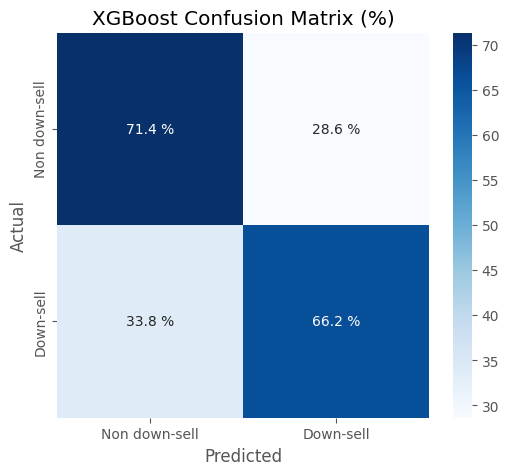

Confusion matrix in percentages:
[[71.36 28.64]
 [33.81 66.19]]


In [457]:
from sklearn.metrics import confusion_matrix

# ---------------------------
# Confusion matrix (percentage)
# ---------------------------
cm = confusion_matrix(y_test, y_pred_xgb)

# Normalize by row (each actual class = 100%)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6,5))
ax = sns.heatmap(cm_percent, 
                 annot=True, 
                 fmt='.1f', 
                 cmap='Blues',
                 xticklabels=['Non down-sell', 'Down-sell'],
                 yticklabels=['Non down-sell', 'Down-sell'])

# Add % symbol to annotations
for t in ax.texts:
    t.set_text(t.get_text() + " %")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('XGBoost Confusion Matrix (%)')
plt.show()

print("Confusion matrix in percentages:")
print(np.round(cm_percent, 2))

Decile analysis (Decile 1 = highest score):
 decile  n_clients  n_downsell  ds_rate     lift  pct_ds_captured
      1      17142       15687 0.915121 2.264736        22.646167
      2      17142       10827 0.631607 1.563096        38.276310
      3      17142        8948 0.521993 1.291825        51.193879
      4      17142        7729 0.450881 1.115837        62.351667
      5      17142        6799 0.396628 0.981573        72.166883
      6      17142        5836 0.340450 0.842545        80.591887
      7      17142        4840 0.282347 0.698752        87.579039
      8      17142        3929 0.229203 0.567231        93.251047
      9      17142        2946 0.171859 0.425315        97.503970
     10      17151        1729 0.100810 0.249485       100.000000


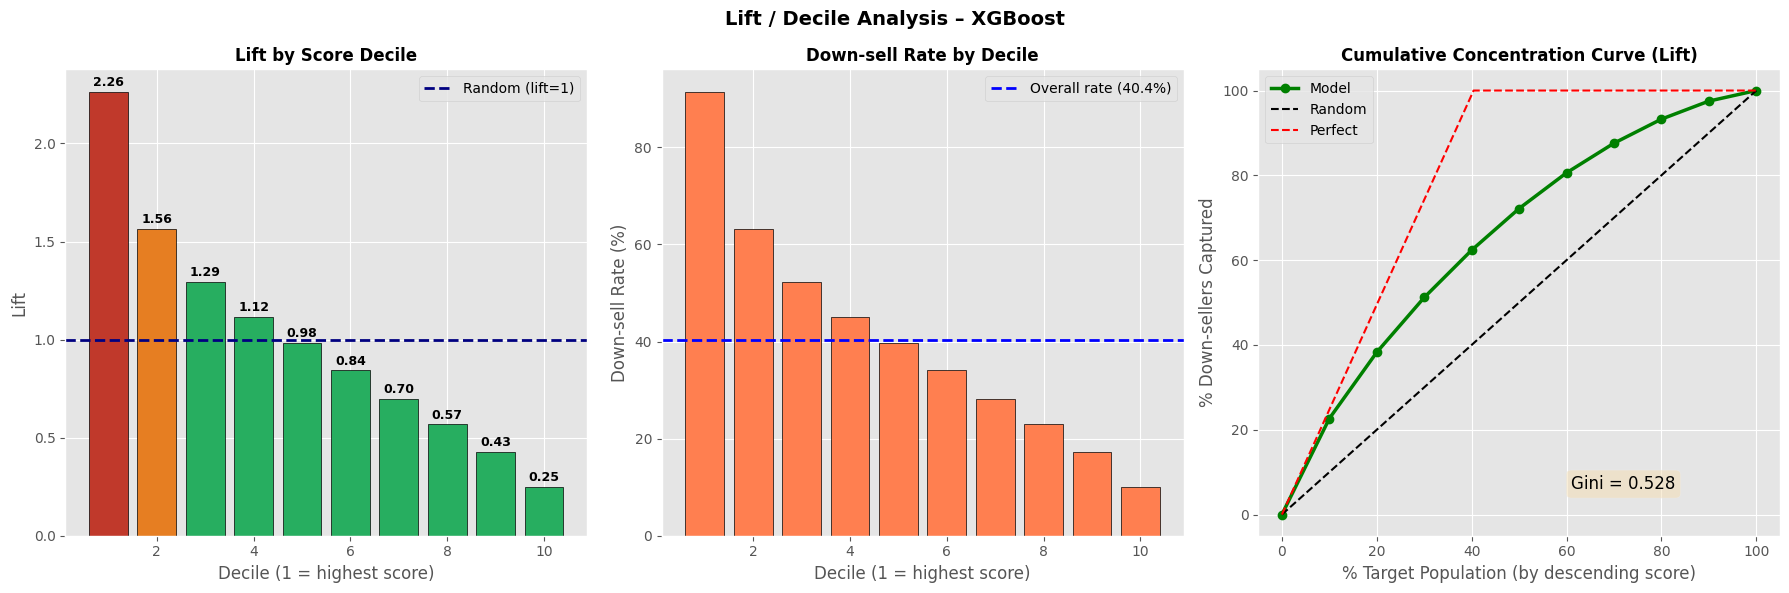


Gini Coefficient: 0.5284


In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# ================================
# LIFT / DECILE ANALYSIS – XGBoost
# ================================

# DataFrame of scoring sorted by descending probability
scoring_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_proba': y_proba_xgb
}).sort_values('y_proba', ascending=False).reset_index(drop=True)

N = len(scoring_df)
scoring_df['decile'] = np.clip(scoring_df.index // (N // 10) + 1, 1, 10)

overall_rate = y_test.mean()

decile_stats = scoring_df.groupby('decile').agg(
    n_clients   = ('y_true', 'count'),
    n_downsell  = ('y_true', 'sum'),
    ds_rate     = ('y_true', 'mean')
).reset_index()

decile_stats['lift']            = decile_stats['ds_rate'] / overall_rate
decile_stats['pct_ds_captured'] = decile_stats['n_downsell'].cumsum() / scoring_df['y_true'].sum() * 100
decile_stats['pct_population']  = decile_stats['n_clients'].cumsum() / N * 100

print("Decile analysis (Decile 1 = highest score):")
print(decile_stats[['decile', 'n_clients', 'n_downsell',
                     'ds_rate', 'lift', 'pct_ds_captured']].to_string(index=False))

# ================================
# Plots
# ================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1️ Lift by decile
bar_colors = ['#c0392b' if l >= 2 else '#e67e22' if l >= 1.5 else '#27ae60'
              for l in decile_stats['lift']]
axes[0].bar(decile_stats['decile'], decile_stats['lift'], color=bar_colors, edgecolor='black')
axes[0].axhline(y=1, color='navy', linestyle='--', linewidth=2, label='Random (lift=1)')
axes[0].set_title("Lift by Score Decile", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Decile (1 = highest score)")
axes[0].set_ylabel("Lift")
axes[0].legend()
for i, (d, l) in enumerate(zip(decile_stats['decile'], decile_stats['lift'])):
    axes[0].text(d, l + 0.03, f"{l:.2f}", ha='center', fontsize=9, fontweight='bold')

# 2️ Down-sell rate by decile
axes[1].bar(decile_stats['decile'], decile_stats['ds_rate'] * 100,
            color='coral', edgecolor='black')
axes[1].axhline(y=overall_rate * 100, color='blue', linestyle='--',
                linewidth=2, label=f'Overall rate ({overall_rate:.1%})')
axes[1].set_title("Down-sell Rate by Decile", fontweight='bold', fontsize=12)
axes[1].set_xlabel("Decile (1 = highest score)")
axes[1].set_ylabel("Down-sell Rate (%)")
axes[1].legend()

# 3️ Cumulative concentration curve (cumulative lift)
axes[2].plot([0] + list(decile_stats['pct_population']),
             [0] + list(decile_stats['pct_ds_captured']),
             'g-o', linewidth=2.5, label='Model', markersize=6)
axes[2].plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='Random')
axes[2].plot([0, overall_rate * 100, 100], [0, 100, 100], 'r--', linewidth=1.5, label='Perfect')
axes[2].set_title("Cumulative Concentration Curve (Lift)", fontweight='bold', fontsize=12)
axes[2].set_xlabel("% Target Population (by descending score)")
axes[2].set_ylabel("% Down-sellers Captured")
axes[2].legend()
axes[2].grid(True)

# Gini coefficient
gini = 2 * roc_auc_score(y_test, y_proba_xgb) - 1
axes[2].annotate(f"Gini = {gini:.3f}", xy=(0.6, 0.1),
                 xycoords='axes fraction', fontsize=12,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f"Lift / Decile Analysis – XGBoost", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nGini Coefficient: {gini:.4f}")

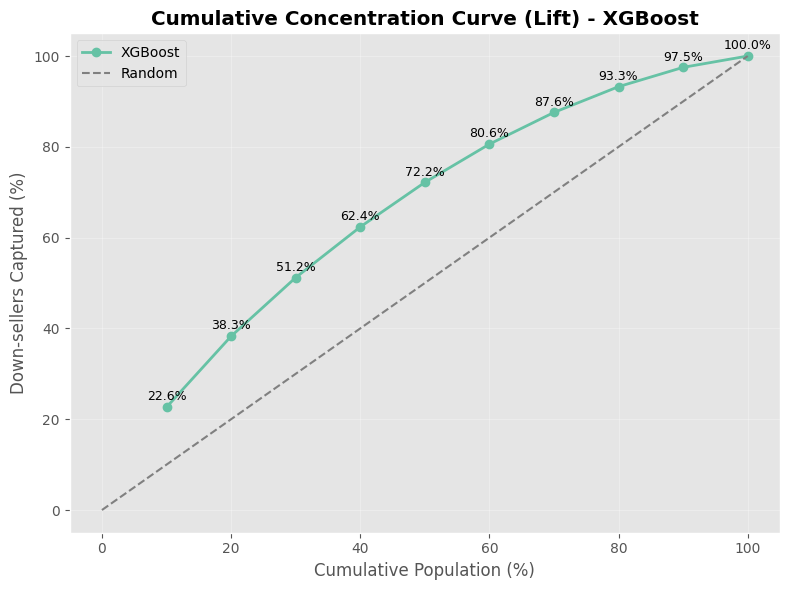

In [397]:
# ================================
# XGBoost Data Preparation
# ================================
results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba_xgb   # Use XGBoost predicted probabilities
}).sort_values('y_proba', ascending=False).reset_index(drop=True)

# Create deciles (0 = top 10% probability)
results['decile'] = pd.qcut(results.index, 10, labels=False)

decile_table = results.groupby('decile')['y_true'].agg(['count', 'sum']).reset_index()
decile_table.columns = ['decile', 'n_clients', 'n_downsell']

# Cumulative gain (%)
decile_table['cumulative_gain'] = (
    decile_table['n_downsell'].cumsum() /
    decile_table['n_downsell'].sum() * 100
)

# Cumulative population (%)
decile_table['cumulative_population'] = (
    decile_table['n_clients'].cumsum() /
    decile_table['n_clients'].sum() * 100
)

# -----------------------------
# Cumulative Concentration Curve
# -----------------------------
plt.figure(figsize=(8,6))

plt.plot(decile_table['cumulative_population'],
         decile_table['cumulative_gain'],
         marker='o',
         linewidth=2,
         label='XGBoost')

# Baseline line (random)
plt.plot([0,100], [0,100], linestyle='--', color='grey', label='Random')

# Show values on points
for x, y in zip(decile_table['cumulative_population'], decile_table['cumulative_gain']):
    plt.text(x, y+1.5, f'{y:.1f}%', ha='center', fontsize=9)

plt.xlabel('Cumulative Population (%)')
plt.ylabel('Down-sellers Captured (%)')
plt.title('Cumulative Concentration Curve (Lift) - XGBoost', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [395]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

# ============================================================
# 4. FINDING THE OPTIMAL THRESHOLD – XGBoost
# ============================================================

print("\n" + "="*60)
print("FINDING THE OPTIMAL THRESHOLD (XGBoost)")
print("="*60)

# Probabilities from the XGBoost model
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find the threshold that maximizes F1 (ignore last element)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

print(f"\nOptimal threshold (max F1): {optimal_threshold:.3f}")
print(f"Optimal F1-score           : {optimal_f1:.4f}")
print(f"Precision at this threshold: {optimal_precision:.4f}")
print(f"Recall at this threshold   : {optimal_recall:.4f}")

# ============================================================
# 5. CONFUSION MATRIX AT OPTIMAL THRESHOLD
# ============================================================

y_pred_optimal = (y_proba_xgb >= optimal_threshold).astype(int)

cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print("\nConfusion Matrix (optimal threshold):")
print(pd.DataFrame(cm_optimal,
                   index=['Actual Stable', 'Actual Down-sell'],
                   columns=['Predicted Stable', 'Predicted Down-sell']))

print("\nClassification Report (optimal threshold):")
print(classification_report(y_test, y_pred_optimal,
                            target_names=['Stable', 'Down-sell']))


FINDING THE OPTIMAL THRESHOLD (XGBoost)

Optimal threshold (max F1): 0.423
Optimal F1-score           : 0.6492
Precision at this threshold: 0.5546
Recall at this threshold   : 0.7826

Confusion Matrix (optimal threshold):
                  Predicted Stable  Predicted Down-sell
Actual Stable                58630                43529
Actual Down-sell             15062                54208

Classification Report (optimal threshold):
              precision    recall  f1-score   support

      Stable       0.80      0.57      0.67    102159
   Down-sell       0.55      0.78      0.65     69270

    accuracy                           0.66    171429
   macro avg       0.68      0.68      0.66    171429
weighted avg       0.70      0.66      0.66    171429



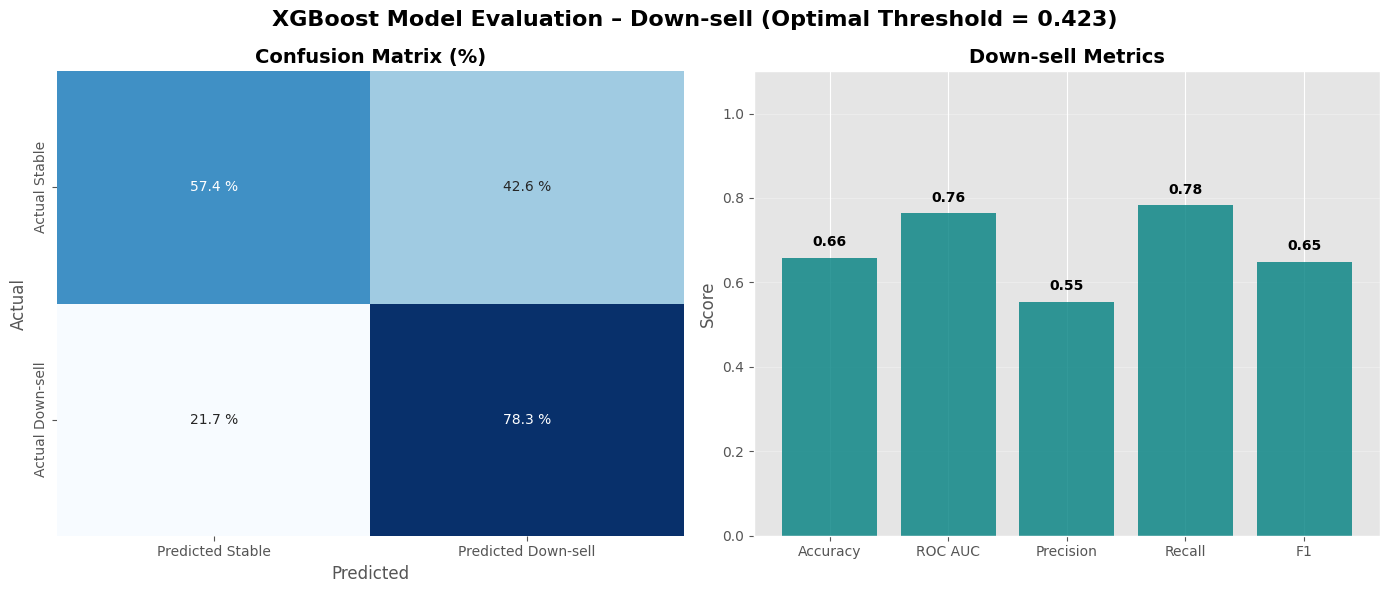

In [456]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# ------------------------------
# 1️ Confusion Matrix (Percentages)
# ------------------------------
cm = confusion_matrix(y_test, y_pred_optimal)

# Convert to percentages by row (actual class normalization)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

cm_df = pd.DataFrame(cm_percent,
                     index=['Actual Stable', 'Actual Down-sell'],
                     columns=['Predicted Stable', 'Predicted Down-sell'])

# ------------------------------
# 2️ Metrics
# ------------------------------
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_optimal),
    'ROC AUC': roc_auc_score(y_test, y_proba_xgb),
    'Precision': precision_score(y_test, y_pred_optimal),
    'Recall': recall_score(y_test, y_pred_optimal),
    'F1': f1_score(y_test, y_pred_optimal)
}

# ------------------------------
# 3️ Plotting
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Heatmap (Percentages)
sns.heatmap(cm_df, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix (%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Add % symbol manually
for t in axes[0].texts:
    t.set_text(t.get_text() + " %")

# Bar chart for metrics
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())

bars = axes[1].bar(metrics_names, metrics_values, color='teal', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", 
                 ha='center', va='bottom', fontweight='bold')

axes[1].set_ylim(0, 1.1)
axes[1].set_ylabel('Score')
axes[1].set_title('Down-sell Metrics', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('XGBoost Model Evaluation – Down-sell (Optimal Threshold = 0.423)', 
             fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

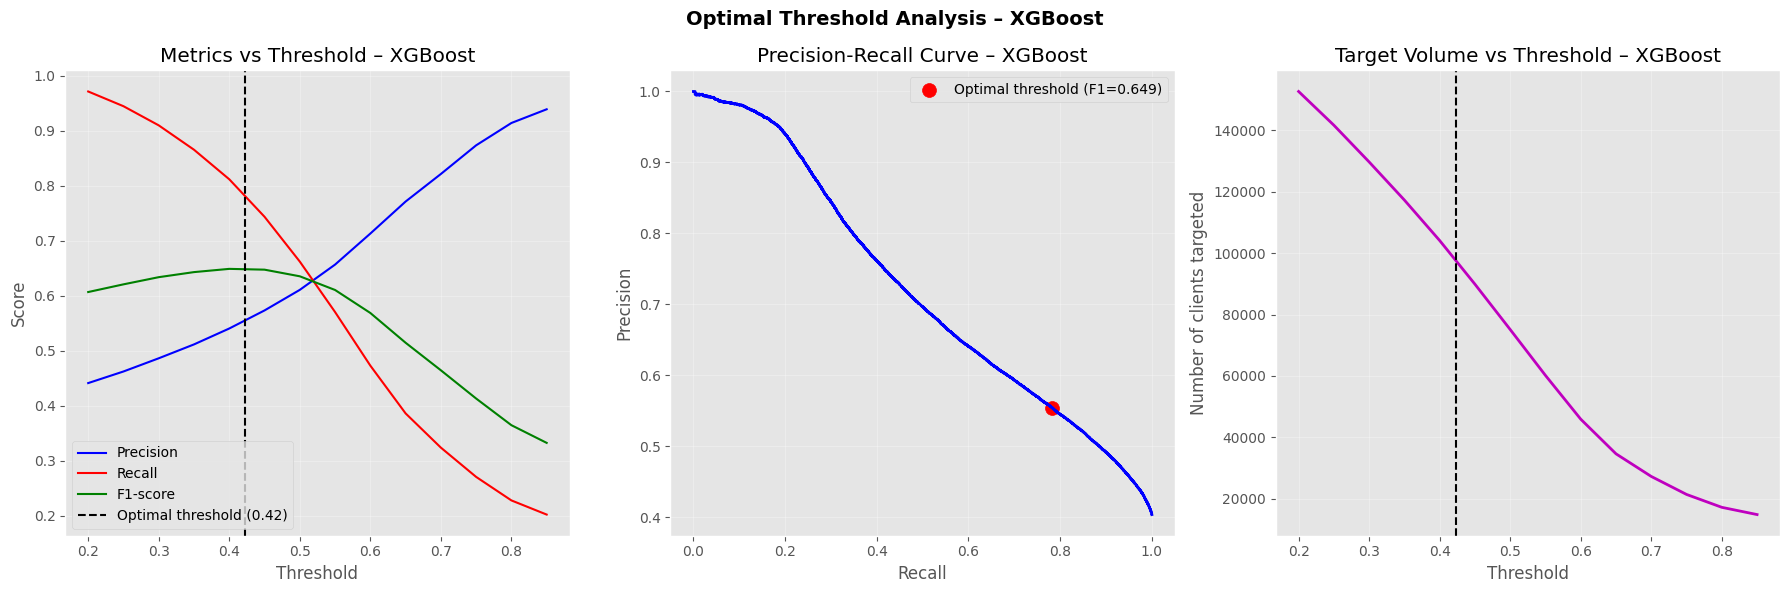


OPTIMAL THRESHOLD SUMMARY – XGBoost
- Optimal threshold      : 0.423
- F1-score               : 0.6492
- Precision              : 0.5546
- Recall                 : 0.7826
- Clients targeted       : 97737
- Targeting rate         : 57.01%


In [455]:
# ============================================================
# 7. VISUALIZATION OF THRESHOLD IMPACT – XGBOOST
# ============================================================

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ------------------------------------------------------------
# PRECISION / RECALL / F1 VS THRESHOLD
# ------------------------------------------------------------

# Precision-Recall curve for optimal threshold calculation
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

# Threshold grid for evaluation
thresholds_eval = np.arange(0.2, 0.9, 0.05)
precisions_eval = []
recalls_eval = []
f1s_eval = []

for t in thresholds_eval:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    precisions_eval.append(precision_score(y_test, y_pred_t))
    recalls_eval.append(recall_score(y_test, y_pred_t))
    f1s_eval.append(f1_score(y_test, y_pred_t))

axes[0].plot(thresholds_eval, precisions_eval, 'b-', label='Precision')
axes[0].plot(thresholds_eval, recalls_eval, 'r-', label='Recall')
axes[0].plot(thresholds_eval, f1s_eval, 'g-', label='F1-score')
axes[0].axvline(x=optimal_threshold, color='black', linestyle='--',
                label=f'Optimal threshold ({optimal_threshold:.2f})')

axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Threshold – XGBoost')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ------------------------------------------------------------
# PRECISION-RECALL CURVE
# ------------------------------------------------------------

axes[1].plot(recall, precision, 'b-', linewidth=2)
axes[1].scatter(optimal_recall, optimal_precision,
                color='red', s=100,
                label=f'Optimal threshold (F1={optimal_f1:.3f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve – XGBoost')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------------------
# TARGET VOLUME VS THRESHOLD
# ------------------------------------------------------------

axes[2].plot(thresholds_eval,
             [sum(y_proba_xgb >= t) for t in thresholds_eval],
             'm-', linewidth=2)

axes[2].axvline(x=optimal_threshold, color='black', linestyle='--')

axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Number of clients targeted')
axes[2].set_title('Target Volume vs Threshold – XGBoost')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Optimal Threshold Analysis – XGBoost',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# FINAL DISPLAY OF OPTIMAL THRESHOLD
# ============================================================

print("\nOPTIMAL THRESHOLD SUMMARY – XGBoost")
print(f"- Optimal threshold      : {optimal_threshold:.3f}")
print(f"- F1-score               : {optimal_f1:.4f}")
print(f"- Precision              : {optimal_precision:.4f}")
print(f"- Recall                 : {optimal_recall:.4f}")
print(f"- Clients targeted       : {(y_proba_xgb >= optimal_threshold).sum()}")
print(f"- Targeting rate         : {(y_proba_xgb >= optimal_threshold).mean():.2%}")

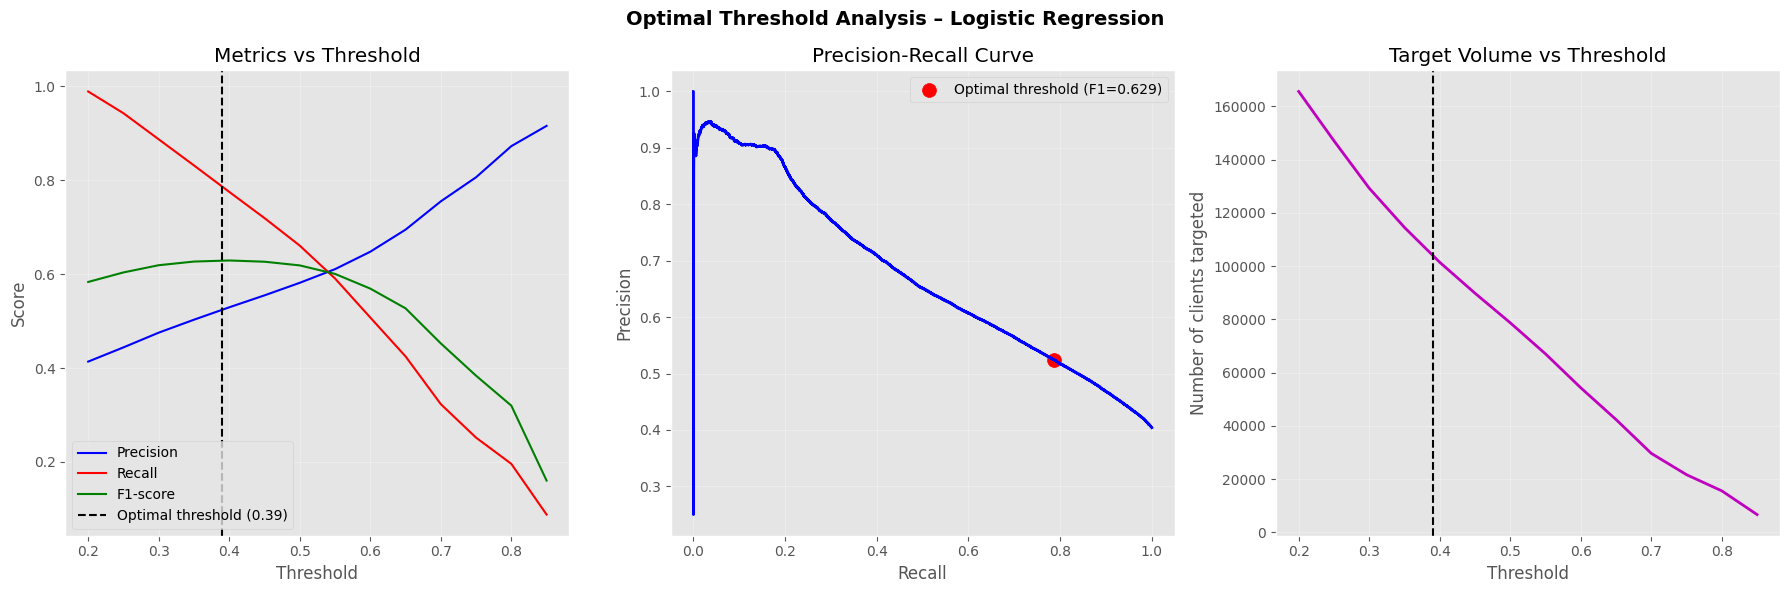


OPTIMAL THRESHOLD SUMMARY
- Optimal threshold      : 0.390
- F1-score               : 0.6294
- Precision              : 0.5244
- Recall                 : 0.7870
- Clients targeted       : 103946
- Targeting rate         : 60.64%


In [398]:
# ============================================================
# 7. VISUALIZATION OF THRESHOLD IMPACT
# ============================================================

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ------------------------------------------------------------
# PRECISION / RECALL / F1 VS THRESHOLD
# ------------------------------------------------------------

# Precision-Recall curve for optimal threshold calculation
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
optimal_precision = precision[optimal_idx]
optimal_recall = recall[optimal_idx]

# Thresholds for analysis
thresholds_eval = np.arange(0.2, 0.9, 0.05)
precisions_eval = []
recalls_eval = []
f1s_eval = []

for t in thresholds_eval:
    y_pred_t = (y_proba_lr >= t).astype(int)
    precisions_eval.append(precision_score(y_test, y_pred_t))
    recalls_eval.append(recall_score(y_test, y_pred_t))
    f1s_eval.append(f1_score(y_test, y_pred_t))

axes[0].plot(thresholds_eval, precisions_eval, 'b-', label='Precision')
axes[0].plot(thresholds_eval, recalls_eval, 'r-', label='Recall')
axes[0].plot(thresholds_eval, f1s_eval, 'g-', label='F1-score')
axes[0].axvline(x=optimal_threshold, color='black', linestyle='--',
                label=f'Optimal threshold ({optimal_threshold:.2f})')

axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ------------------------------------------------------------
# PRECISION-RECALL CURVE
# ------------------------------------------------------------
axes[1].plot(recall, precision, 'b-', linewidth=2)
axes[1].scatter(optimal_recall, optimal_precision, color='red', s=100,
                marker='o', label=f'Optimal threshold (F1={optimal_f1:.3f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------------------
# TARGET VOLUME VS THRESHOLD
# ------------------------------------------------------------
axes[2].plot(thresholds_eval, [sum(y_proba_lr >= t) for t in thresholds_eval],
            'm-', linewidth=2)

axes[2].axvline(x=optimal_threshold, color='black', linestyle='--')

axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Number of clients targeted')
axes[2].set_title('Target Volume vs Threshold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Optimal Threshold Analysis – Logistic Regression',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# FINAL DISPLAY OF OPTIMAL THRESHOLD
# ============================================================

print("\nOPTIMAL THRESHOLD SUMMARY")
print(f"- Optimal threshold      : {optimal_threshold:.3f}")
print(f"- F1-score               : {optimal_f1:.4f}")
print(f"- Precision              : {optimal_precision:.4f}")
print(f"- Recall                 : {optimal_recall:.4f}")
print(f"- Clients targeted       : {(y_proba_lr >= optimal_threshold).sum()}")
print(f"- Targeting rate         : {(y_proba_lr >= optimal_threshold).mean():.2%}")

In [411]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

# ============================================================
# FUNCTION TO COMPUTE METRICS AT A GIVEN THRESHOLD
# ============================================================
def compute_metrics(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

# ============================================================
# METRICS AT OPTIMAL THRESHOLD
# ============================================================
train_metrics = compute_metrics(y_train, xgb.predict_proba(X_train_final)[:, 1], optimal_threshold)
test_metrics  = compute_metrics(y_test,  y_proba_xgb, optimal_threshold)

# Combine in DataFrame for easy display
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Accuracy': [train_metrics['Accuracy'], test_metrics['Accuracy']],
    'Recall': [train_metrics['Recall'], test_metrics['Recall']],
    'F1-score': [train_metrics['F1-score'], test_metrics['F1-score']],
    'ROC-AUC': [train_metrics['ROC-AUC'], test_metrics['ROC-AUC']]
})

# Format numbers nicely
metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']] = metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']].applymap(lambda x: f"{x:.4f}")

print(metrics_df)

  Dataset Accuracy  Recall F1-score ROC-AUC
0   Train   0.6442  0.8291   0.6531  0.7719
1    Test   0.6382  0.8238   0.6479  0.7642


C:\Users\USER\AppData\Local\Temp\ipykernel_30068\3834780594.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']] = metrics_df[['Accuracy','Recall','F1-score','ROC-AUC']].applymap(lambda x: f"{x:.4f}")


ECONOMIC DECISION - ROI & TARGETING (DOWN-SELL)

----------------------------------------
ECONOMIC ASSUMPTIONS
----------------------------------------
Global down-sell rate : 40.4%
Cost per action       : 250 FCFA
Average value saved    : 25,000 FCFA

----------------------------------------
ROI BY DECILE (ANALYSIS)
----------------------------------------
 decile  n_clients down_rate  expected_down     total_cost  retained     value_saved     net_benefit    roi
    1.0      17142     91.5%          15687 4,285,500 FCFA      1882 47,050,000 FCFA 42,764,500 FCFA 997.9%
    2.0      17142     63.2%          10827 4,285,500 FCFA      1299 32,475,000 FCFA 28,189,500 FCFA 657.8%
    3.0      17142     52.2%           8948 4,285,500 FCFA      1073 26,825,000 FCFA 22,539,500 FCFA 525.9%
    4.0      17142     45.1%           7729 4,285,500 FCFA       927 23,175,000 FCFA 18,889,500 FCFA 440.8%
    5.0      17142     39.7%           6799 4,285,500 FCFA       815 20,375,000 FCFA 16,089,500 FCFA

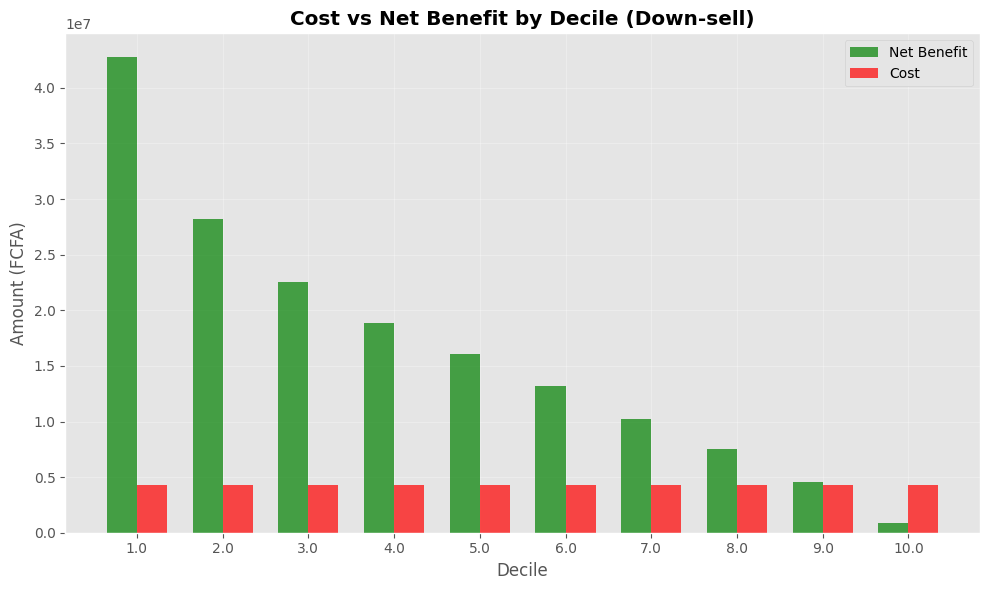


----------------------------------------
CUMULATIVE ROI - OPTIMAL TARGETING
----------------------------------------
   targeting  cumulative_clients cumulative_cost cumulative_benefit cumulative_roi
 Deciles 1-1               17142  4,285,500 FCFA    42,764,500 FCFA         997.9%
 Deciles 1-2               34284  8,571,000 FCFA    70,954,000 FCFA         827.8%
 Deciles 1-3               51426 12,856,500 FCFA    93,493,500 FCFA         727.2%
 Deciles 1-4               68568 17,142,000 FCFA   112,383,000 FCFA         655.6%
 Deciles 1-5               85710 21,427,500 FCFA   128,472,500 FCFA         599.6%
 Deciles 1-6              102852 25,713,000 FCFA   141,687,000 FCFA         551.0%
 Deciles 1-7              119994 29,998,500 FCFA   151,901,500 FCFA         506.4%
 Deciles 1-8              137136 34,284,000 FCFA   159,391,000 FCFA         464.9%
 Deciles 1-9              154278 38,569,500 FCFA   163,930,500 FCFA         425.0%
Deciles 1-10              171429 42,857,250 FCFA   1

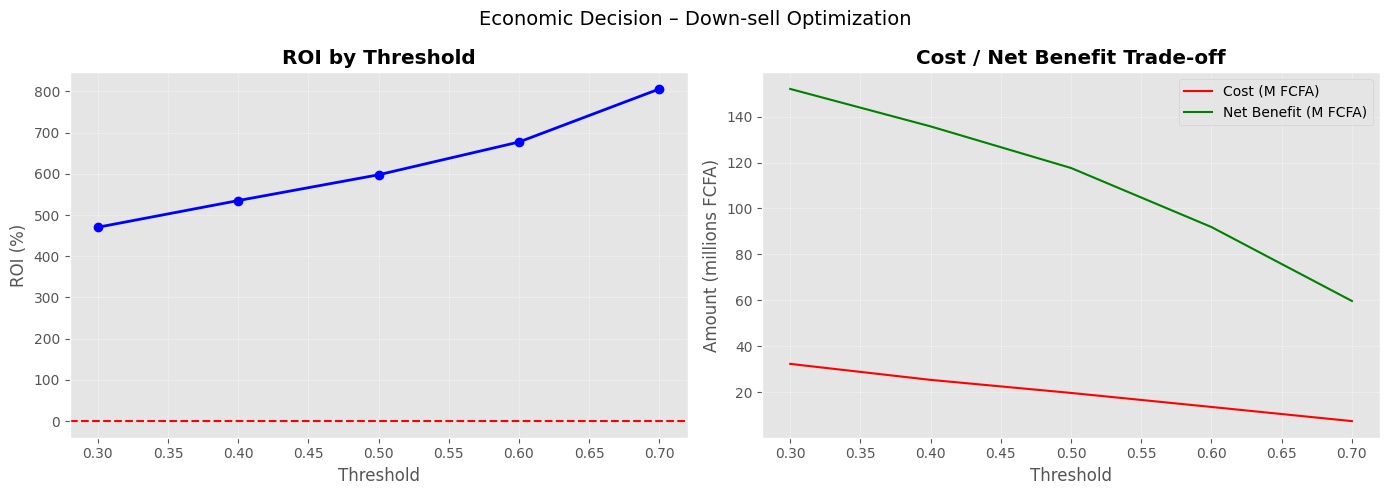

In [459]:
# ============================================================
# ECONOMIC DECISION - ROI & TARGETING (DOWN-SELL)
# ============================================================

print("="*60)
print("ECONOMIC DECISION - ROI & TARGETING (DOWN-SELL)")
print("="*60)

# ============================================================
# 1. BUSINESS ASSUMPTIONS
# ============================================================

print("\n" + "-"*40)
print("ECONOMIC ASSUMPTIONS")
print("-"*40)

# Cost of a retention action / customer contact
ACTION_COST = 250      # FCFA (SMS, call, retention offer)

# Average value lost if the customer down-sells
VALUE_SAVED = 25000    # FCFA (average ARPU or preserved margin)

# Global down-sell rate (already calculated)
print(f"Global down-sell rate : {taux_global*100:.1f}%")
print(f"Cost per action       : {ACTION_COST:,.0f} FCFA")
print(f"Average value saved    : {VALUE_SAVED:,.0f} FCFA")

# Assumed effectiveness of action
ACTION_EFFECTIVENESS = 0.12  # 12% of contacted down-sellers are retained

# ============================================================
# 2. ROI BY DECILE
# ============================================================

print("\n" + "-"*40)
print("ROI BY DECILE (ANALYSIS)")
print("-"*40)

roi_deciles = []

for _, row in decile_stats.iterrows():
    n_clients = int(row['n_clients'])
    down_rate = row['ds_rate']
    expected_down = int(n_clients * down_rate)

    # Total cost if contacting the entire decile
    total_cost = n_clients * ACTION_COST

    # Value saved (ACTION_EFFECTIVENESS of down-sellers are retained)
    retained = int(expected_down * ACTION_EFFECTIVENESS)
    value_saved = retained * VALUE_SAVED

    net_benefit = value_saved - total_cost
    roi = (net_benefit / total_cost * 100) if total_cost > 0 else 0

    roi_deciles.append({
        'decile': row['decile'],
        'n_clients': n_clients,
        'down_rate': f"{down_rate*100:.1f}%",
        'expected_down': expected_down,
        'total_cost': f"{total_cost:,.0f} FCFA",
        'retained': retained,
        'value_saved': f"{value_saved:,.0f} FCFA",
        'net_benefit': f"{net_benefit:,.0f} FCFA",
        'roi': f"{roi:.1f}%"
    })

roi_df = pd.DataFrame(roi_deciles)
print(roi_df.to_string(index=False))

# ============================================================
# 3. ROI BY DECILE – BAR CHART
# ============================================================

plt.figure(figsize=(10, 6))

net_benefits = [float(b.replace(' FCFA','').replace(',','')) for b in roi_df['net_benefit']]
costs = [float(c.replace(' FCFA','').replace(',','')) for c in roi_df['total_cost']]

x = np.arange(len(roi_df))
width = 0.35

plt.bar(x - width/2, net_benefits, width, label='Net Benefit', color='green', alpha=0.7)
plt.bar(x + width/2, costs, width, label='Cost', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Decile')
plt.ylabel('Amount (FCFA)')
plt.title('Cost vs Net Benefit by Decile (Down-sell)', fontweight='bold')
plt.xticks(x, roi_df['decile'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 4. CUMULATIVE ROI & OPTIMAL TARGETING
# ============================================================

print("\n" + "-"*40)
print("CUMULATIVE ROI - OPTIMAL TARGETING")
print("-"*40)

cumulative_roi = []
cum_benefit = 0
cum_cost = 0

for idx, row in roi_df.iterrows():
    cost = float(row['total_cost'].replace(' FCFA','').replace(',',''))
    benefit = float(row['net_benefit'].replace(' FCFA','').replace(',',''))

    cum_cost += cost
    cum_benefit += benefit
    roi_cum = (cum_benefit / cum_cost * 100) if cum_cost > 0 else 0

    cumulative_roi.append({
        'targeting': f"Deciles 1-{idx+1}",
        'cumulative_clients': sum(int(roi_df.iloc[i]['n_clients']) for i in range(idx+1)),
        'cumulative_cost': f"{cum_cost:,.0f} FCFA",
        'cumulative_benefit': f"{cum_benefit:,.0f} FCFA",
        'cumulative_roi': f"{roi_cum:.1f}%"
    })

cumulative_roi_df = pd.DataFrame(cumulative_roi)
print(cumulative_roi_df.to_string(index=False))

# ============================================================
# 5. ROI SIMULATION BY THRESHOLD
# ============================================================

print("\n" + "-"*40)
print("ROI SIMULATION BY THRESHOLD")
print("-"*40)

thresholds_test = [0.3, 0.4, 0.5, 0.6, 0.7]
scenarios = []

for threshold in thresholds_test:
    y_pred_thr = (y_proba_lr >= threshold).astype(int)

    n_targeted = y_pred_thr.sum()
    n_down_targeted = (y_test[y_pred_thr == 1] == 1).sum()

    total_cost = n_targeted * ACTION_COST
    n_retained = int(n_down_targeted * ACTION_EFFECTIVENESS)
    value = n_retained * VALUE_SAVED
    net_benefit = value - total_cost

    scenarios.append({
        'threshold': threshold,
        'clients_targeted': n_targeted,
        '%_clients': f"{n_targeted/len(y_test)*100:.1f}%",
        'down_targeted': n_down_targeted,
        'total_cost': f"{total_cost:,.0f} FCFA",
        'value_saved': f"{value:,.0f} FCFA",
        'net_benefit': f"{net_benefit:,.0f} FCFA",
        'roi': f"{net_benefit/total_cost*100:.1f}%" if total_cost > 0 else "N/A"
    })

scenarios_df = pd.DataFrame(scenarios)
print(scenarios_df.to_string(index=False))

# ============================================================
# 6. MARKETING RECOMMENDATION
# ============================================================

print("\n" + "="*60)
print("RECOMMENDATION TO MARKETING DIRECTOR")
print("="*60)

# Best scenario (max ROI)
valid_scenarios = [s for s in scenarios if s['roi'] != "N/A"]
best = max(valid_scenarios, key=lambda s: float(s['roi'].replace('%','')))

print(f"""
1. Recommended targeting: probability > {best['threshold']}  
   → {best['clients_targeted']} clients ({best['%_clients']})

2. Expected impact:  
   → {best['down_targeted']} potential down-sellers  
   → approx. {int(best['down_targeted']*ACTION_EFFECTIVENESS)} clients retained

3. Estimated ROI:  
   → Investment      : {best['total_cost']}  
   → Net benefit     : {best['net_benefit']}  
   → ROI             : {best['roi']}

4. Interpretation: Decile 1 shows the highest risk and greatest potential
   value preserved → retention priority.

5. Action plan: run an A/B test on 10% of the target, measure retention,
   then deploy broadly if results are confirmed.
""")

# ============================================================
# 7. ROI VS THRESHOLD – SUMMARY PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROI vs threshold
rois_plot = [float(s['roi'].replace('%','')) for s in scenarios if s['roi'] != "N/A"]
thresholds_plot = [s['threshold'] for s in scenarios if s['roi'] != "N/A"]

axes[0].plot(thresholds_plot, rois_plot, 'bo-', linewidth=2)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('ROI (%)')
axes[0].set_title('ROI by Threshold', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cost vs net benefit
x_thr = [s['threshold'] for s in scenarios]
y_costs = [float(s['total_cost'].replace(' FCFA','').replace(',',''))/1e6 for s in scenarios]
y_benefits = [float(s['net_benefit'].replace(' FCFA','').replace(',',''))/1e6 for s in scenarios]

axes[1].plot(x_thr, y_costs, 'r-', label='Cost (M FCFA)')
axes[1].plot(x_thr, y_benefits, 'g-', label='Net Benefit (M FCFA)')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Amount (millions FCFA)')
axes[1].set_title('Cost / Net Benefit Trade-off', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Economic Decision – Down-sell Optimization', fontsize=14)
plt.tight_layout()
plt.show()



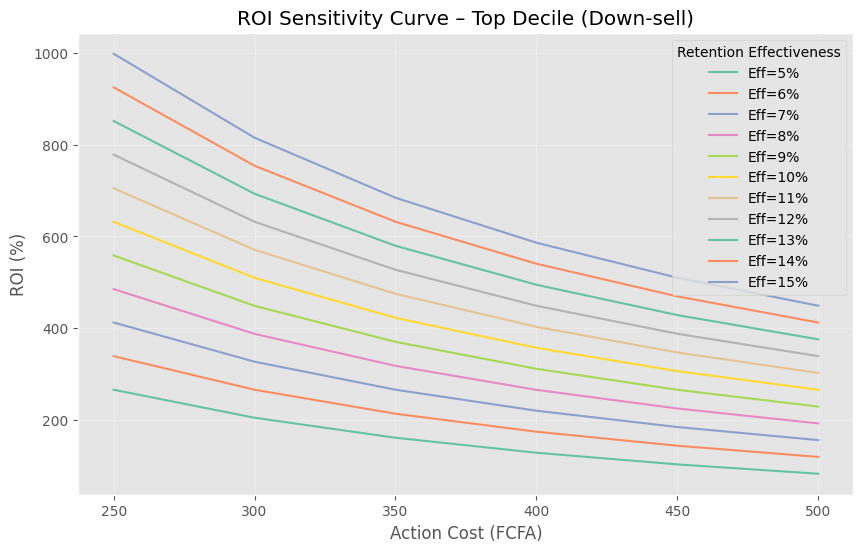

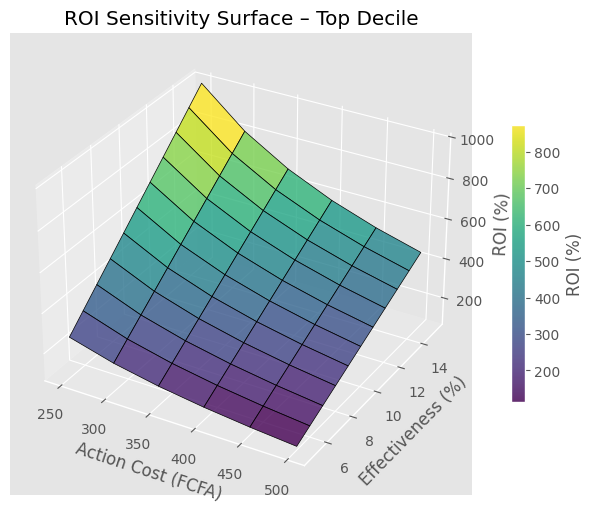

In [408]:

# Assumption ranges
effectiveness_range = np.arange(0.05, 0.16, 0.01)   # 5% to 15%
action_cost_range = np.arange(250, 501, 50)          # 250 to 500 FCFA
value_saved_range = np.arange(15000, 25001, 2500)    # 15k to 25k FCFA

# Pick a single decile for simplicity (top decile)
row = decile_stats.iloc[0]
n_clients = int(row['n_clients'])
down_rate = row['ds_rate']
expected_down = int(n_clients * down_rate)

# Prepare ROI results
roi_matrix = np.zeros((len(effectiveness_range), len(action_cost_range)))

for i, eff in enumerate(effectiveness_range):
    for j, cost in enumerate(action_cost_range):
        # Take median of value_saved_range just for simplicity
        value_saved = np.median(value_saved_range)
        retained = int(expected_down * eff)
        total_cost = n_clients * cost
        net_benefit = retained * value_saved - total_cost
        roi_matrix[i, j] = net_benefit / total_cost * 100

# Plot ROI curves for different effectiveness levels
plt.figure(figsize=(10,6))
for i, eff in enumerate(effectiveness_range):
    plt.plot(action_cost_range, roi_matrix[i, :], label=f'Eff={eff*100:.0f}%')

plt.xlabel('Action Cost (FCFA)')
plt.ylabel('ROI (%)')
plt.title('ROI Sensitivity Curve – Top Decile (Down-sell)')
plt.grid(True, alpha=0.3)
plt.legend(title='Retention Effectiveness')
plt.show()

# Optional: 3D surface (effectiveness vs action cost)
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(action_cost_range, effectiveness_range)
Z = roi_matrix

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y*100, Z, cmap='viridis', edgecolor='k', alpha=0.8)
ax.set_xlabel('Action Cost (FCFA)')
ax.set_ylabel('Effectiveness (%)')
ax.set_zlabel('ROI (%)')
ax.set_title('ROI Sensitivity Surface – Top Decile')
fig.colorbar(surf, shrink=0.6, label='ROI (%)')
plt.show()

In [400]:
print(decile_stats.columns)

Index(['decile', 'n_clients', 'n_downsell', 'ds_rate', 'lift',
       'pct_ds_captured', 'pct_population'],
      dtype='object')


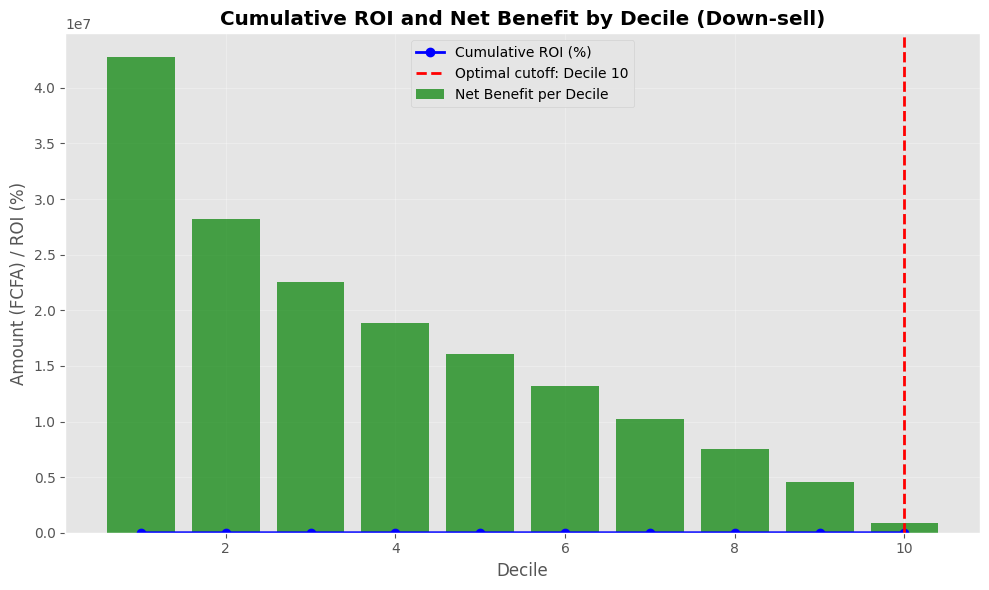

In [402]:

# Extract numeric values from roi_df
net_benefits = [float(x.replace(' FCFA','').replace(',','')) for x in roi_df['net_benefit']]
costs = [float(x.replace(' FCFA','').replace(',','')) for x in roi_df['total_cost']]

# Compute cumulative sums
cum_benefit = np.cumsum(net_benefits)
cum_cost = np.cumsum(costs)
cum_roi = cum_benefit / cum_cost * 100

# Identify optimal cutoff decile: ROI above 100% (or choose your threshold)
optimal_idx = np.argmax(cum_roi < 100)  # first decile where cumulative ROI drops below 100%
if optimal_idx == 0:  # if all deciles ROI > 100%
    optimal_idx = len(cum_roi) - 1

x = roi_df['decile']

plt.figure(figsize=(10,6))

# Bar chart: net benefit per decile
plt.bar(x, net_benefits, label='Net Benefit per Decile', color='green', alpha=0.7)

# Line: cumulative ROI
plt.plot(x, cum_roi, 'bo-', linewidth=2, markersize=6, label='Cumulative ROI (%)')

# Highlight optimal decile
plt.axvline(x=x[optimal_idx], color='red', linestyle='--', linewidth=2, label=f'Optimal cutoff: Decile {int(x[optimal_idx])}')

# Labels
plt.xlabel('Decile')
plt.ylabel('Amount (FCFA) / ROI (%)')
plt.title('Cumulative ROI and Net Benefit by Decile (Down-sell)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

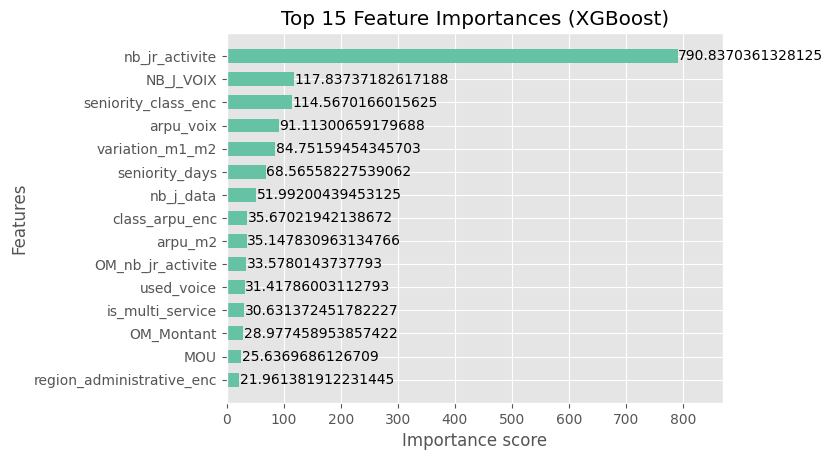

In [403]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

if XGBOOST_AVAILABLE:
    plt.figure(figsize=(10,6))
    plot_importance(xgb, max_num_features=15, importance_type='gain', 
                    title='Top 15 Feature Importances (XGBoost)', height=0.6)
    plt.show()
else:
    print("XGBoost not installed; use GradientBoosting feature importance instead.")

Top 15 Features by Importance (%):
                  feature  importance_pct
           nb_jr_activite       49.379722
                NB_J_VOIX        7.357744
      seniority_class_enc        7.153544
                arpu_voix        5.689080
          variation_m1_m2        5.291874
           seniority_days        4.281223
                nb_j_data        3.246371
           class_arpu_enc        2.227242
                  arpu_m2        2.194624
        OM_nb_jr_activite        2.096605
               used_voice        1.961726
         is_multi_service        1.912617
               OM_Montant        1.809347
                      MOU        1.600768
region_administrative_enc        1.371265


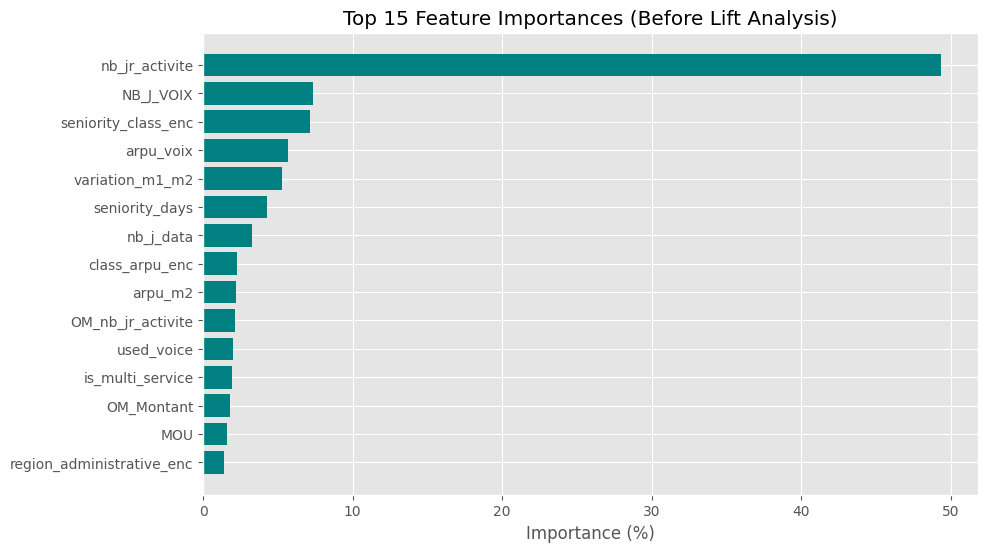

In [404]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------------------
# 1️⃣ Extract Feature Importance
# ------------------------------
if XGBOOST_AVAILABLE:
    # Get gain-based importance
    importance_dict = xgb.get_booster().get_score(importance_type='gain')
    total_gain = sum(importance_dict.values())
    
    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance_pct': [v / total_gain * 100 for v in importance_dict.values()]
    }).sort_values(by='importance_pct', ascending=False)
else:
    # For GradientBoostingClassifier
    importances = xgb.feature_importances_
    total_importance = importances.sum()
    
    importance_df = pd.DataFrame({
        'feature': X_train_final.columns,
        'importance_pct': importances / total_importance * 100
    }).sort_values(by='importance_pct', ascending=False)

# ------------------------------
# 2️⃣ Display Top Features
# ------------------------------
print("Top 15 Features by Importance (%):")
print(importance_df.head(15).to_string(index=False))

# ------------------------------
# 3️⃣ Optional: Horizontal Bar Plot
# ------------------------------
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'][:15][::-1], importance_df['importance_pct'][:15][::-1], color='teal')
plt.xlabel('Importance (%)')
plt.title('Top 15 Feature Importances (Before Lift Analysis)')
plt.show()